# Final Data Cleaning and Modeling Notebook
## Project: Predicting NFL Outcomes Using Machine Learning
## Author: Nicholas Romano
## DS450-01: Data Science Senior Capstone
---
This notebook is the up-to-date Data Cleaning and Modeling Jupyter Notebook .ipynb file for this project. The initial Data Cleaning and Modeling Jupyter Notebook named `Data_Cleaning_and_Modeling_Notebook.ipynb` was the Data Cleaning and Modeling Notebook that was used for the preliminary modeling and celebration of student research presentation at Bellarmine University Apr. 16, 2024.

Changes Made Include: 
- A correction in the dropped columns. In the EDA Notebook, I noticed that the redzone efficiency statistics were not consistently recorded. As a result, I made the decision to remove the columns correpsonding to the redxone efficiency statistics. However, not all the redzone efficiency statistics were dropped in the `Data_Cleaning_and_Modeling_Notebook.ipynb` Notebook that was used for the preliminary modeling.
- More moving average team dataframes that have differing periods to see which period of previous games is the most accurate.
- Incorporating more models, other than just the K-Nearest Neighbors Classification Model.

---

## Importing Libraries and Dataset

### Importing Libraries

In [1]:
# Data Storing, Manipulation, and Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Modeling, Model Evaluation Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

### Importing Dataset

In [2]:
df = pd.read_csv("EDA_Expanded_NFL_Data.csv")

## Data Cleaning & Manipulating

### Dropping Tied Games

**`valueData(column)` function** - The `valueData(column)` function takes a column of the dataframe, retrieves the data count and frequencies of the values within the column passed within the parameter list. Then the function combines the count and frequency dataframes into a single dataframe, updates the column names then returns the single combined dataframe.

The `valueData(column)` function allows to check the occurence of a value within a column in relation to the other possible values within the column. In the case of tied games, it allows to see the proportion of tied games and whehter it makes a insignificant portion of the game outcomes. If so, the tied game outcomes will be dropped.

In [3]:
def valueData(column):
    counts = df[column].value_counts() #Retrieving Count Data
    frequency = df[column].value_counts(normalize=True) #Retrieving Frequencies
    value_df = pd.concat([counts,frequency], axis = 1) #Combining the two tables into one
    value_df.rename(columns = {"count": "Instances Occured", 
                               "proportion": "Proportion of Total Instances Occured"},
                   inplace =True)
    return value_df

By checking the `game_result` column values by running it through the `valueData()` function, we see that the number of tied gamea makes up a small proportion of the total games played. The 14 tied games correspond to just under one-fourth of 1%. Since tied games make up such a small number of the overall number of games, it was decided to drop the tied games from the dataset.

With the tied games dropped, the problem of predicting the outcomes of NFL games has become a binary classification problem. Either the home or away team wins.

**Checking the value counts and frequencties for the game_result column**

In [4]:
valueData('game_result')

,Instances Occured,Proportion of Total Instances Occured
game_result,,
1,3180,0.563730
0,2447,0.433788
2,14,0.002482


**Removing the tied games from the dataset**

In [5]:
#Getting a list of all the index values that represent a game ending in a tie
tied_games = df[df["game_result"] == 2].index.to_list()

#Dropping the index values that represent a game that ended in a tie
df.drop(tied_games, inplace=True)

#Resetting the index to accomadate for the doppted rows
df.reset_index(drop = True, inplace = True)

#Redisplaying the game_result values to see if the tied games did in fact get dropped
valueData('game_result')

,Instances Occured,Proportion of Total Instances Occured
game_result,,
1,3180,0.565132
0,2447,0.434868


---
### Dropping Postseason Games From the Dataset

One thing that I noticed while doing the EDA was the presence of Postseason games in the dataset. The concerning aspect about the presence of NFL postseason games is the fact that teams who regularly reach and make deep runs in the playoffs over the past 20 seaons (like the Patriots) will have more games played in comparison to teams that regularly miss reaching the playoffs. 

In creating the model based on this data, it would make sense to try and make every team play a similar amount of games. In that regard, dropping postseason games is one avenue to go down since all teams play the same number of regular season games.  

The following block of code creates two dataframes one for the number of home games played and one for the number of away games played, then concatenates both dataframes into one dataframe. Finally the combined dataframe is sorted in descending order in terms of the number of games played from most to least. As you can see in the output from block of code below, the range between the Patriots and Lions is 38 games. Removing the postseason games will shrink the differences in the number of games played from team to team.

**Retrieving the number of home games, away games, and total games played for each NFL game**

In [6]:
#Number of home games for each NFL Team
homeGames = pd.DataFrame(df.home.groupby(df.home).count())

#Number of away games for each NFL Team
awayGames = pd.DataFrame(df.away.groupby(df.away).count())

#Concatening the home and away game Dataframes
gamesPlayed = pd.concat([homeGames, awayGames], axis = 1)

#Adding a 'total_games_played' column which is the sum of the home and away games played
gamesPlayed["total_games_played"] = gamesPlayed.sum(axis = 1)

#Sorting the total_games_played column
gamesPlayed.sort_values(["total_games_played"], ascending = False, inplace =True)

#Displaying the dataframe
gamesPlayed

,home,away,total_games_played
Patriots,196,181,377
Seahawks,182,183,365
Colts,181,182,363
Packers,182,181,363
Eagles,184,177,361
Ravens,175,185,360
Chiefs,185,175,360
Steelers,179,180,359
49ers,177,179,356
Saints,179,176,355


**Dropping the NFL Postseason Games**

To solve the problem of the differing amount of games played due to postseason games played, manually scraped data of the dates of the postseason games during the seasons included in the dataset. The data was retreieved manually from the ESPN's `NFL Schedule` tab and going through the needed seasons then recording the date of first postseason game and the superbowl. The date of the first postseason game is the first string in the list and the data of the Superbowl is the second string in the list. The link to the page that I retrieved the data is provided here: <a href= "https://www.espn.com/nfl/schedule/_/week/5/year/2022/seasontype/3">ESPN NFL Schedule Webpage</a> .

To got about dropping the postseason games:
- The `postSeasonGames(startingDate, endingDate)` function was created to retrieve the games that occured in each of the seasons postseasons based on the dates retrieved from ESPN.
- The `postSeasonDates` dictionary stores a key-value pair consisting of the NFL season, the date of the first NFL postseason game of that season, and the Superbowl of that year. The key is the year that the NFL regular season started in - so the first key is 2002 representing the 2002-2003 season and the second key is the 2003-2004 season - and the values are a list of two values representing the start and end of the postseason of the given NFL Season.
- Then by creating a list named `postSeasonGamesList` and looping through the keys of `postSeasonDates` dictionary, I was able to retrieve the index values of all the postseason games and store the values in the `postSeasonGamesList`, which would be used to eventually drop the rows corresponding to the index values within the list.

***`postSeasonGames()` function to return the list of the index positions of postseason games for each season***

In [7]:
def postSeasonGames(startingDate, endingDate):
    return df.loc[(startingDate <= df.date) & (df.date <= endingDate)].index.values.tolist()

***Using a dictionary `postSeasonDates` to store the dates for which each postseason game took place. Looping throuhg each key-value pair to retrieve the index positions of all the postseason games and storing the index positions in the `postSeasonGamesList`***

In [8]:
#Converting df.date to datetime
df.date = pd.to_datetime(df.date)

#Creating the postSeasonDates dictionary (season: ["Date of First Postseason Game of Season", "Date of Superbowl that Season])
postSeasonDates = {2002: ["2003-01-04", "2003-01-26"],
                   2003: ["2004-01-03", "2004-02-01"],
                   2004: ["2005-01-08", "2005-02-06"],
                   2005: ["2006-01-07", "2006-02-05"],
                   2006: ["2007-01-06", "2007-02-04"],
                   2007: ["2008-01-05", "2008-02-03"],
                   2008: ["2009-01-03", "2009-02-01"],
                   2009: ["2010-01-09", "2010-02-07"],
                   2010: ["2011-01-08", "2011-02-06"],
                   2011: ["2012-01-07", "2012-02-05"],
                   2012: ["2013-01-05", "2013-02-03"],
                   2013: ["2014-01-04", "2014-02-02"],
                   2014: ["2015-01-03", "2015-02-01"],
                   2015: ["2016-01-09", "2016-02-07"],
                   2016: ["2017-01-07", "2017-02-05"],
                   2017: ["2018-01-06", "2018-02-04"],
                   2018: ["2019-01-05", "2019-02-03"],
                   2019: ["2020-01-04", "2020-02-02"],
                   2020: ["2021-01-09", "2021-02-07"],
                   2021: ["2022-01-15", "2022-02-13"],
                   2022: ["2023-01-14", "2023-02-12"]}

#postSeasonGamesList to store all postseason games index values
postSeasonGamesList = []

#Iterating through each season, retrieving the index postions between the start and ending date of that seasons playoffs
#then adding those values to the postSeasonGamesList
for season in postSeasonDates.keys():
    individualYearPostSeasonList = list()
    individualYearPostSeasonList = postSeasonGames(postSeasonDates.get(season)[0], postSeasonDates.get(season)[1])

    for date in individualYearPostSeasonList:
        postSeasonGamesList.append(date)

***Checking the number of postseason games relative to the total number of games within the dataset***

In [9]:
print(f"Number of Postseason Games in the Dataset: {len(postSeasonGamesList)}")
print(f"Total Number of Games in the Dataset: {len(df)}")
print(f"Percentage of Games That Are Postseason Games: {(len(postSeasonGamesList)/len(df))* 100}%")

Number of Postseason Games in the Dataset: 237
Total Number of Games in the Dataset: 5627
Percentage of Games That Are Postseason Games: 4.2118357917185%


***Dropping the postseason games from the dataset, then checking the home, away, and total games played to see that each team has played a similar number of games. Differing numbers in the number of games played is due to dropped games due to ties***

In [10]:
#Dropping the postseason games from the dataframe and resetting the index to take into account the missing rows.
df.drop(postSeasonGamesList, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
#Creating a dataframe that contains the number of home games for each team
homeGames = pd.DataFrame(df.home.groupby(df.home).count())

#Creating a dataframe that contains the number of away games for each team
awayGames = pd.DataFrame(df.away.groupby(df.away).count())

#Combining the home and away game numbers for each team, summing the total games played, and sorting in descending order
gamesPlayed = pd.concat([homeGames, awayGames], axis = 1)
gamesPlayed["total_games_played"] = gamesPlayed.sum(axis = 1)
gamesPlayed.sort_values(['total_games_played'], ascending = False)

,home,away,total_games_played
Bears,169,169,338
Titans,169,169,338
Broncos,169,169,338
Saints,169,169,338
Ravens,169,169,338
Chargers,169,169,338
Chiefs,169,169,338
Raiders,169,169,338
Patriots,169,169,338
Dolphins,169,169,338


### Getting Dataframes for each NFL Team

The overall goal was to build off of the future reasearch proposition of Matt Gifford and Tuncay Bayrak's article in *Decision Analytics Journal* titled “A predictive analytics model for forecasting outcomes in the National Football League games using decision tree and logistic regression.” They proposed the future research idea of trying to use recent prior performances to predict the result of upcoming games. With that goal in mind, my approach was to get the average statistics of recent games from each team entering a given game to see if I could accurately predict the outcome of the game. 

Setting up to do this, entails:
- Getting 1 dataframe for each individual NFL team consisting of the games that they played (regardless of whether the games was home or away)
- Transforming the dataframes for each individual NFL team so that each row is an average of the previous *n* games played
- Combining the transformed dataframes back into one overall dataframe

#### Functions Created

The `teamDataFrame` function was created in expediating the process of retrieving the away and home game data for each NFL team and combining it into a single Dataframe with just the games that a specific team played. It first retrieves the away games, then retrieves a rearranged home game dataframe the columns match those of the away game dataframe, then concatenates the two dataframes, and finally sorts the dataframe by data so the games are arranged in the order they were played.

In [12]:
def teamDataFrame(teamName):
    #Querying the games in which the specific team was the away team
    awayDF = df.query(f"away == '{teamName}'")

    #A list of the renamed columns, so that when the away game and home game dataframes are combined both will share the same columns
    renamedColumns = ['date', 
                      'away', 
                      'home',
                      'offensive_first_downs',
                      'offensive_third_down_conversions', 
                      'offensive_third_down_opportunities',
                      'offensive_fourth_down_conversions', 
                      'offensive_fourth_down_conversion_attempts',
                      'offensive_passing_completions', 
                      'offensive_passing_attempts',
                      'offensive_passing_yards', 
                      'offensive_rushing_attempts', 
                      'offensive_rushing_yards',
                      'offensive_total_yards', 
                      'offensive_sacks_taken', 
                      'offensive_yards_lost_from_sacks',
                      'offensive_fumbles', 
                      'offensive_interceptions', 
                      'offensive_turnovers', 
                      'offensive_penalties',
                      'offensive_penalty_yards', 
                      'offensive_redzone_conversions',
                      'offensive_redzone_drives', 
                      'team_def_st_td', 
                      'offensive_drives',
                      'team_offensive_time_of_possession', 
                      'defensive_first_downs_allowed', 
                      'defensive_third_down_conversions_allowed',
                      'defensive_third_down_opportunities', 
                      'defensive_fourth_down_conversions_allowed',
                      'defensive_fourth_down_conversion_attempts', 
                      'defensive_passing_completions',
                      'defensive_passing_attempts', 
                      'defensive_passing_yards_allowed', 
                      'defensive_rushing_attempts',
                      'defensive_rushing_yards_allowed', 
                      'defensive_total_yards_allowed', 
                      'defensive_sacks',
                      'defensive_sack_yards', 
                      'defensive_fumbles_forced', 
                      'defensive_int_forced', 
                      'defensive_turnovers_forced',
                      'opposing_team_team_penalties', 
                      'opposing_team_penalty_yards', 
                      'defensive_redzone_conversions',
                      'defensive_redzone_opportunities', 
                      'opposing_team_def_st_td', 
                      'opposing_team_drives',
                      'opposing_team_possession',
                      'points_scored', 
                      'points_allowed', 
                      'game_result']

    #Renaming the columns within awayDF to be that of those in the renamedColumns list
    awayDF.columns = renamedColumns

    #Querying the home games for specific team. This dataframe is rearranged to match that of the awayDF.
    #awayDF has the indivial team stats then opposing team stats after, since that is how it was in the original df
    homeDF = df.query(f"home == '{teamName}'")[['date', 
                                                'away', 
                                                'home', 
                                                'first_downs_home', 
                                                'third_down_conversions_home',
                                                'third_down_opportunities_home', 
                                                'fourth_down_conversions_home',
                                                'fourth_down_conversion_attempts_home', 
                                                'passing_completions_home',
                                                'passing_attempts_home', 
                                                'passing_yards_home', 
                                                'rushing_attempts_home',
                                                'rushing_yards_home', 
                                                'total_yards_home', 
                                                'times_sacked_home',
                                                'sack_yards_lost_home', 
                                                'fumbles_home', 
                                                'int_home', 
                                                'turnovers_home',
                                                'team_penalties_home', 
                                                'penalty_yards_home', 
                                                'redzone_conversions_home',
                                                'redzone_opportunities_home', 
                                                'def_st_td_home', 
                                                'drives_home',
                                                'possession_home', 
                                                'first_downs_away',
                                                'third_down_conversions_away', 
                                                'third_down_opportunities_away',
                                                'fourth_down_conversions_away', 
                                                'fourth_down_conversion_attempts_away',
                                                'passing_completions_away', 
                                                'passing_attempts_away',
                                                'passing_yards_away', 
                                                'rushing_attempts_away', 
                                                'rushing_yards_away',
                                                'total_yards_away', 
                                                'times_sacked_away', 
                                                'sack_yards_lost_away',
                                                'fumbles_away', 
                                                'int_away', 
                                                'turnovers_away', 
                                                'team_penalties_away',
                                                'penalty_yards_away', 
                                                'redzone_conversions_away',
                                                'redzone_opportunities_away', 
                                                'def_st_td_away', 
                                                'drives_away',
                                                'possession_away', 
                                                'score_away', 
                                                'score_home', 
                                                'game_result']]
    
    #Renaming the columns to those in the renamedColumns list
    homeDF.columns = renamedColumns

    #Concatinging both the awayDF and homeDF
    teamDF = pd.concat([awayDF, homeDF])

    #Sorting the teamDF by date so the games are in order from when they occured.
    teamDF.sort_values(by = ["date"], ascending = True, inplace = True)
    
    return teamDF

The `teamRollingAverages` function expediates the process of generating the average statistics of a teams pervious number of games. The function takes in a TeamDataFrame, the number of games to include in the averaging of statistics, and the teamName. The function takes the average of the numerical statistics of the specificed number games in the parameter list, if the number of previous games is less than the specified numnber of games it still takes the average of the previous past games, but it would just include fewer games. Then the function shifts the averages down one row since the rolling method includes the row in the calculations and the goal is to include previous game data, so the `.shift(periods = 1)` takes care of that. Finally, the team score, opponent score, and game result are added to the end of the columns, and the date, team, opponent are added to the beginning of the columns. *Note: the opponent is added using the `opponent()` function.*

In [13]:
def teamRollingAverages(TeamDataFrame, RollingAVG_Period, teamName):
    #Calculates rolling averages of the specified number of periods in the parameter list (RollingAVG_Period)
    teamAvg_df = TeamDataFrame[['offensive_first_downs', 'offensive_third_down_conversions', 'offensive_third_down_opportunities',
                                'offensive_fourth_down_conversions', 'offensive_fourth_down_conversion_attempts',
                                'offensive_passing_completions', 'offensive_passing_attempts', 'offensive_passing_yards', 
                                'offensive_rushing_attempts', 'offensive_rushing_yards', 'offensive_total_yards', 
                                'offensive_sacks_taken', 'offensive_yards_lost_from_sacks', 
                                'offensive_fumbles', 'offensive_interceptions', 'offensive_turnovers', 'offensive_penalties','offensive_penalty_yards', 
                                'offensive_redzone_conversions','offensive_redzone_drives', 'team_def_st_td', 'offensive_drives','team_offensive_time_of_possession', 
                                'defensive_first_downs_allowed', 'defensive_third_down_conversions_allowed','defensive_third_down_opportunities', 
                                'defensive_fourth_down_conversions_allowed','defensive_fourth_down_conversion_attempts', 
                                'defensive_passing_completions','defensive_passing_attempts', 'defensive_passing_yards_allowed', 
                                'defensive_rushing_attempts','defensive_rushing_yards_allowed', 'defensive_total_yards_allowed', 
                                'defensive_sacks','defensive_sack_yards', 'defensive_fumbles_forced', 'defensive_int_forced', 'defensive_turnovers_forced',
                                'opposing_team_team_penalties', 'opposing_team_penalty_yards', 
                                'defensive_redzone_conversions','defensive_redzone_opportunities', 
                                'opposing_team_def_st_td', 'opposing_team_drives','opposing_team_possession',
                                'points_scored', 'points_allowed']].rolling(RollingAVG_Period, min_periods = 1).mean().shift(periods = 1)

    #Entering the scores, date, team, and opponent columns to the teamAVG_df. They are the same as the teamDF, except for the opponent column
    #The opponent function takes care the oppent column
    teamAvg_df.insert(48, 'team_score', -1)
    teamAvg_df.team_score = TeamDataFrame.points_scored
    teamAvg_df.insert(49, 'opponent_score', -1)
    teamAvg_df.opponent_score = TeamDataFrame.points_allowed
    teamAvg_df.insert(50, 'game_result', -1)
    teamAvg_df.game_result = TeamDataFrame.game_result
    teamAvg_df.insert(0, 'opponent', "")
    teamAvg_df.insert(0, 'team', f'{teamName}')
    teamAvg_df.insert(0, 'date', 0)
    teamAvg_df.date = TeamDataFrame.date
    

    return teamAvg_df

The `opponent` function fills in the opponent in the teamAvgDataframe. It does this by looping throught the team average statistics dataframe index and retrieving the opponent by retrieving the opponent in the nonAverage team statistic dataframe.

In [14]:
def opponent(teamDataframe, teamAvgDataFrame, teamName):
    
    for gameIndex in teamAvgDataFrame.index.tolist():
        
        #If the home team is the team whose dataframe oppondent column is being modified, the value in the opponent column for the teamAVG dataframe
        #is set to the away team in the nonAvg team dataframe
        if (teamDataframe.loc[gameIndex, 'home'] == teamName):
            teamAvgDataFrame.loc[gameIndex, 'opponent'] = teamDataframe.loc[gameIndex, 'away']

        #Otherwise the the value in the opponent column for the teamAVG dataframe
        #is set to the home team in the nonAvg team dataframe
        else:
            teamAvgDataFrame.loc[gameIndex, 'opponent'] = teamDataframe.loc[gameIndex, 'home']


**Functions Created to Combine the 32 NFL Team Average Dataframes into a Single Dataframe**
To transfer the data from the teamAVG datasets to a single dataframe, two functions were created: `awayTeamData` and `homeTeamData`. Both functions take in: the dataframe that is going to store the average statistical values for each team for each game (`overallDF`), one teams average statistics dataframe (`teamAvg`), and the team name (`teamName`).

The `awayTeamData` function works by retrieving and iterating through the index values for a specific team's away games and stores the values in the appropriate column correpsonding to that indexValue within the overall dataframe that will eventually store all the game data with the team averages. The `homeTeamData` function works similarly but works by retrieving and iterating through the index values for a specific team's home games and stores the values in the appropriate column correpsonding to that indexValue within the overall dataframe. 

Using the index values works because when I created the individual team and individual team average statistic dataframes I never reset the index values. Therefore the index values in the eventuall overall dataframe and the individual team dataframes will be the same.

In [15]:
def awayTeamData(overallDF, teamAvgDF, teamName):
    for indexValue in overallDF.query(f"away == '{teamName}'").index.tolist():
        overallDF.loc[indexValue, 'offensive_first_downs_away'] = teamAvgDF.loc[indexValue, 'offensive_first_downs']
        overallDF.loc[indexValue, 'offensive_third_down_conversions_away'] = teamAvgDF.loc[indexValue, 'offensive_third_down_conversions']
        overallDF.loc[indexValue, 'offensive_third_down_opportunities_away'] = teamAvgDF.loc[indexValue, 'offensive_third_down_opportunities']
        overallDF.loc[indexValue, 'offensive_fourth_down_conversions_away'] = teamAvgDF.loc[indexValue, 'offensive_fourth_down_conversions']
        overallDF.loc[indexValue, 'offensive_fourth_down_conversion_attempts_away'] = teamAvgDF.loc[indexValue, 'offensive_fourth_down_conversion_attempts']
        overallDF.loc[indexValue, 'offensive_passing_completions_away'] = teamAvgDF.loc[indexValue, 'offensive_passing_completions']
        overallDF.loc[indexValue, 'offensive_passing_attempts_away'] = teamAvgDF.loc[indexValue, 'offensive_passing_attempts']
        overallDF.loc[indexValue, 'offensive_passing_yards_away'] = teamAvgDF.loc[indexValue, 'offensive_passing_yards']
        overallDF.loc[indexValue, 'offensive_rushing_attempts_away'] = teamAvgDF.loc[indexValue, 'offensive_rushing_attempts']
        overallDF.loc[indexValue, 'offensive_rushing_yards_away'] = teamAvgDF.loc[indexValue, 'offensive_rushing_yards']
        overallDF.loc[indexValue, 'offensive_total_yards_away'] = teamAvgDF.loc[indexValue, 'offensive_total_yards']
        overallDF.loc[indexValue, 'offensive_sacks_taken_away'] = teamAvgDF.loc[indexValue, 'offensive_sacks_taken']
        overallDF.loc[indexValue, 'offensive_yards_lost_from_sacks_away'] = teamAvgDF.loc[indexValue, 'offensive_yards_lost_from_sacks']
        overallDF.loc[indexValue, 'offensive_fumbles_away'] = teamAvgDF.loc[indexValue, 'offensive_fumbles']
        overallDF.loc[indexValue, 'offensive_interceptions_away'] = teamAvgDF.loc[indexValue, 'offensive_interceptions']
        overallDF.loc[indexValue, 'offensive_turnovers_away'] = teamAvgDF.loc[indexValue, 'offensive_turnovers']
        overallDF.loc[indexValue, 'offensive_penalties_away'] = teamAvgDF.loc[indexValue, 'offensive_penalties']
        overallDF.loc[indexValue, 'offensive_penalty_yards_away'] = teamAvgDF.loc[indexValue, 'offensive_penalty_yards']
        overallDF.loc[indexValue, 'offensive_redzone_conversions_away'] = teamAvgDF.loc[indexValue, 'offensive_redzone_conversions']
        overallDF.loc[indexValue, 'offensive_redzone_drives_away'] = teamAvgDF.loc[indexValue, 'offensive_redzone_drives']
        overallDF.loc[indexValue, 'team_def_st_td_away'] = teamAvgDF.loc[indexValue, 'team_def_st_td']
        overallDF.loc[indexValue, 'offensive_drives_away'] = teamAvgDF.loc[indexValue, 'offensive_drives']
        overallDF.loc[indexValue, 'team_offensive_time_of_possession_away'] = teamAvgDF.loc[indexValue, 'team_offensive_time_of_possession']
        overallDF.loc[indexValue, 'defensive_first_downs_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_first_downs_allowed']
        overallDF.loc[indexValue, 'defensive_third_down_conversions_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_third_down_conversions_allowed']
        overallDF.loc[indexValue, 'defensive_third_down_opportunities_away'] = teamAvgDF.loc[indexValue, 'defensive_third_down_opportunities']
        overallDF.loc[indexValue, 'defensive_fourth_down_conversions_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_fourth_down_conversions_allowed']
        overallDF.loc[indexValue, 'defensive_fourth_down_conversion_attempts_away'] = teamAvgDF.loc[indexValue, 'defensive_fourth_down_conversion_attempts']
        overallDF.loc[indexValue, 'defensive_passing_completions_away'] = teamAvgDF.loc[indexValue, 'defensive_passing_completions']
        overallDF.loc[indexValue, 'defensive_passing_attempts_away'] = teamAvgDF.loc[indexValue, 'defensive_passing_attempts']
        overallDF.loc[indexValue, 'defensive_passing_yards_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_passing_yards_allowed']
        overallDF.loc[indexValue, 'defensive_rushing_attempts_away'] = teamAvgDF.loc[indexValue, 'defensive_rushing_attempts']
        overallDF.loc[indexValue, 'defensive_rushing_yards_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_rushing_yards_allowed']
        overallDF.loc[indexValue, 'defensive_total_yards_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_total_yards_allowed']
        overallDF.loc[indexValue, 'defensive_sacks_away'] = teamAvgDF.loc[indexValue, 'defensive_sacks']
        overallDF.loc[indexValue, 'defensive_sack_yards_away'] = teamAvgDF.loc[indexValue, 'defensive_sack_yards']
        overallDF.loc[indexValue, 'defensive_fumbles_forced_away'] = teamAvgDF.loc[indexValue, 'defensive_fumbles_forced']
        overallDF.loc[indexValue, 'defensive_int_forced_away'] = teamAvgDF.loc[indexValue, 'defensive_int_forced']
        overallDF.loc[indexValue, 'defensive_turnovers_forced_away'] = teamAvgDF.loc[indexValue, 'defensive_turnovers_forced']
        overallDF.loc[indexValue, 'opposing_team_team_penalties_away'] = teamAvgDF.loc[indexValue, 'opposing_team_team_penalties']
        overallDF.loc[indexValue, 'opposing_team_penalty_yards_away'] = teamAvgDF.loc[indexValue, 'opposing_team_penalty_yards']
        overallDF.loc[indexValue, 'defensive_redzone_conversions_away'] = teamAvgDF.loc[indexValue, 'defensive_redzone_conversions']
        overallDF.loc[indexValue, 'defensive_redzone_opportunities_away'] = teamAvgDF.loc[indexValue, 'defensive_redzone_opportunities']
        overallDF.loc[indexValue, 'opposing_team_def_st_td_away'] = teamAvgDF.loc[indexValue, 'opposing_team_def_st_td']
        overallDF.loc[indexValue, 'opposing_team_drives_away'] = teamAvgDF.loc[indexValue, 'opposing_team_drives']
        overallDF.loc[indexValue, 'opposing_team_possession_away'] = teamAvgDF.loc[indexValue, 'opposing_team_possession']
        overallDF.loc[indexValue, 'points_scored_away'] = teamAvgDF.loc[indexValue, 'points_scored']
        overallDF.loc[indexValue, 'points_allowed_away'] = teamAvgDF.loc[indexValue, 'points_allowed']

In [16]:
def homeTeamData(overallDF, teamAvgDF, teamName):
    for indexValue in overallDF.query(f"home == '{teamName}'").index.tolist():
        overallDF.loc[indexValue, 'offensive_first_downs_home'] = teamAvgDF.loc[indexValue, 'offensive_first_downs']
        overallDF.loc[indexValue, 'offensive_third_down_conversions_home'] = teamAvgDF.loc[indexValue, 'offensive_third_down_conversions']
        overallDF.loc[indexValue, 'offensive_third_down_opportunities_home'] = teamAvgDF.loc[indexValue, 'offensive_third_down_opportunities']
        overallDF.loc[indexValue, 'offensive_fourth_down_conversions_home'] = teamAvgDF.loc[indexValue, 'offensive_fourth_down_conversions']
        overallDF.loc[indexValue, 'offensive_fourth_down_conversion_attempts_home'] = teamAvgDF.loc[indexValue, 'offensive_fourth_down_conversion_attempts']
        overallDF.loc[indexValue, 'offensive_passing_completions_home'] = teamAvgDF.loc[indexValue, 'offensive_passing_completions']
        overallDF.loc[indexValue, 'offensive_passing_attempts_home'] = teamAvgDF.loc[indexValue, 'offensive_passing_attempts']
        overallDF.loc[indexValue, 'offensive_passing_yards_home'] = teamAvgDF.loc[indexValue, 'offensive_passing_yards']
        overallDF.loc[indexValue, 'offensive_rushing_attempts_home'] = teamAvgDF.loc[indexValue, 'offensive_rushing_attempts']
        overallDF.loc[indexValue, 'offensive_rushing_yards_home'] = teamAvgDF.loc[indexValue, 'offensive_rushing_yards']
        overallDF.loc[indexValue, 'offensive_total_yards_home'] = teamAvgDF.loc[indexValue, 'offensive_total_yards']
        overallDF.loc[indexValue, 'offensive_sacks_taken_home'] = teamAvgDF.loc[indexValue, 'offensive_sacks_taken']
        overallDF.loc[indexValue, 'offensive_yards_lost_from_sacks_home'] = teamAvgDF.loc[indexValue, 'offensive_yards_lost_from_sacks']
        overallDF.loc[indexValue, 'offensive_fumbles_home'] = teamAvgDF.loc[indexValue, 'offensive_fumbles']
        overallDF.loc[indexValue, 'offensive_interceptions_home'] = teamAvgDF.loc[indexValue, 'offensive_interceptions']
        overallDF.loc[indexValue, 'offensive_turnovers_home'] = teamAvgDF.loc[indexValue, 'offensive_turnovers']
        overallDF.loc[indexValue, 'offensive_penalties_home'] = teamAvgDF.loc[indexValue, 'offensive_penalties']
        overallDF.loc[indexValue, 'offensive_penalty_yards_home'] = teamAvgDF.loc[indexValue, 'offensive_penalty_yards']
        overallDF.loc[indexValue, 'offensive_redzone_conversions_home'] = teamAvgDF.loc[indexValue, 'offensive_redzone_conversions']
        overallDF.loc[indexValue, 'offensive_redzone_drives_home'] = teamAvgDF.loc[indexValue, 'offensive_redzone_drives']
        overallDF.loc[indexValue, 'team_def_st_td_home'] = teamAvgDF.loc[indexValue, 'team_def_st_td']
        overallDF.loc[indexValue, 'offensive_drives_home'] = teamAvgDF.loc[indexValue, 'offensive_drives']
        overallDF.loc[indexValue, 'team_offensive_time_of_possession_home'] = teamAvgDF.loc[indexValue, 'team_offensive_time_of_possession']
        overallDF.loc[indexValue, 'defensive_first_downs_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_first_downs_allowed']
        overallDF.loc[indexValue, 'defensive_third_down_conversions_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_third_down_conversions_allowed']
        overallDF.loc[indexValue, 'defensive_third_down_opportunities_home'] = teamAvgDF.loc[indexValue, 'defensive_third_down_opportunities']
        overallDF.loc[indexValue, 'defensive_fourth_down_conversions_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_fourth_down_conversions_allowed']
        overallDF.loc[indexValue, 'defensive_fourth_down_conversion_attempts_home'] = teamAvgDF.loc[indexValue, 'defensive_fourth_down_conversion_attempts']
        overallDF.loc[indexValue, 'defensive_passing_completions_home'] = teamAvgDF.loc[indexValue, 'defensive_passing_completions']
        overallDF.loc[indexValue, 'defensive_passing_attempts_home'] = teamAvgDF.loc[indexValue, 'defensive_passing_attempts']
        overallDF.loc[indexValue, 'defensive_passing_yards_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_passing_yards_allowed']
        overallDF.loc[indexValue, 'defensive_rushing_attempts_home'] = teamAvgDF.loc[indexValue, 'defensive_rushing_attempts']
        overallDF.loc[indexValue, 'defensive_rushing_yards_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_rushing_yards_allowed']
        overallDF.loc[indexValue, 'defensive_total_yards_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_total_yards_allowed']
        overallDF.loc[indexValue, 'defensive_sacks_home'] = teamAvgDF.loc[indexValue, 'defensive_sacks']
        overallDF.loc[indexValue, 'defensive_sack_yards_home'] = teamAvgDF.loc[indexValue, 'defensive_sack_yards']
        overallDF.loc[indexValue, 'defensive_fumbles_forced_home'] = teamAvgDF.loc[indexValue, 'defensive_fumbles_forced']
        overallDF.loc[indexValue, 'defensive_int_forced_home'] = teamAvgDF.loc[indexValue, 'defensive_int_forced']
        overallDF.loc[indexValue, 'defensive_turnovers_forced_home'] = teamAvgDF.loc[indexValue, 'defensive_turnovers_forced']
        overallDF.loc[indexValue, 'opposing_team_team_penalties_home'] = teamAvgDF.loc[indexValue, 'opposing_team_team_penalties']
        overallDF.loc[indexValue, 'opposing_team_penalty_yards_home'] = teamAvgDF.loc[indexValue, 'opposing_team_penalty_yards']
        overallDF.loc[indexValue, 'defensive_redzone_conversions_home'] = teamAvgDF.loc[indexValue, 'defensive_redzone_conversions']
        overallDF.loc[indexValue, 'defensive_redzone_opportunities_home'] = teamAvgDF.loc[indexValue, 'defensive_redzone_opportunities']
        overallDF.loc[indexValue, 'opposing_team_def_st_td_home'] = teamAvgDF.loc[indexValue, 'opposing_team_def_st_td']
        overallDF.loc[indexValue, 'opposing_team_drives_home'] = teamAvgDF.loc[indexValue, 'opposing_team_drives']
        overallDF.loc[indexValue, 'opposing_team_possession_home'] = teamAvgDF.loc[indexValue, 'opposing_team_possession']
        overallDF.loc[indexValue, 'points_scored_home'] = teamAvgDF.loc[indexValue, 'points_scored']
        overallDF.loc[indexValue, 'points_allowed_home'] = teamAvgDF.loc[indexValue, 'points_allowed']

#### Functions Used to help clean the teamAVG dataframes

One of the goals is trying to see if a model will be able to predict NFL games after being trained on a small range of data. This is due to the changing game of football to a more pass heavy league that perfers passing over running the football. With having used 16 seasons (2002-2017) worth of data, I elected to trim it down to 10 seasons (2012-2021) to train a model and validate the model using the 2022 season. The two blocks of code below remove the seasons beofre the 2012 season. 

The `SeasonGamesPlayed` function returns the index values of games played within the dates within the `SeasonDatesDictionary`.

The `AVG_Dataframe_Cleaning()` function takes in a dataframe within the parameter list and the filename for which you want to save the dataframe as a csv file. This fuction drops the redzone efficiency columns and also contains the `SeasonDatesDictionary`,which stores the season and a 2 element list containing the start and end date of that particular season. The start and end dates for each season was obtained by using the ESPN schedule webpage and going through each season and obtaining the date of the first game in week 1 and the superbowl (<a href= "https://www.espn.com/nfl/schedule/_/week/5/year/2022/seasontype/3">ESPN NFL Schedule Webpage</a>). Finally, a for loop iterates through each season and obtains the number of games played for each season. (Note: the NFL recently modified its schedule to include 17 regular season games. That is why the 2021-2022 and 2022-2023 seasons have slightly higher game totals).

In [17]:
def SeasonGamesPlayed(startingDate, endingDate, dataframe):
    return dataframe.loc[(startingDate <= dataframe.date) & (dataframe.date < endingDate)].index.values.tolist()

In [18]:
def AVG_Dataframe_Cleaning(dataframe, saveAsName):
    redzone_efficiency_columns = ["offensive_redzone_conversions_away",
                                  "offensive_redzone_drives_away",
                                  "defensive_redzone_conversions_away",
                                  "defensive_redzone_opportunities_away",
                                  "offensive_redzone_conversions_home",
                                  "offensive_redzone_drives_home",
                                  "defensive_redzone_conversions_home",
                                  "defensive_redzone_opportunities_home"]

    dataframe.drop(columns = redzone_efficiency_columns, inplace = True)

    SeasonDatesDictionary = {2002: ["2002-09-01", "2003-01-04"],
                         2003: ["2003-09-01", "2004-01-03"],
                         2004: ["2004-09-01", "2005-01-08"],
                         2005: ["2005-09-01", "2006-01-07"],
                         2006: ["2006-09-01", "2007-01-06"],
                         2007: ["2007-09-01", "2008-01-05"],
                         2008: ["2008-09-01", "2009-01-03"],
                         2009: ["2009-09-01", "2010-01-09"],
                         2010: ["2010-09-01", "2011-01-08"],
                         2011: ["2011-09-01", "2012-01-07"],
                         2012: ["2012-09-01", "2013-01-05"],
                         2013: ["2013-09-01", "2014-01-04"],
                         2014: ["2014-09-01", "2015-01-03"],
                         2015: ["2015-09-01", "2016-01-09"],
                         2016: ["2016-09-01", "2017-01-07"],
                         2017: ["2017-09-01", "2018-01-06"],
                         2018: ["2018-09-01", "2019-01-05"],
                         2019: ["2019-09-01", "2020-01-04"],
                         2020: ["2020-09-01", "2021-01-09"],
                         2021: ["2021-09-01", "2022-01-15"],
                         2022: ["2022-09-01", "2023-01-14"]}
    indexList = []

    for season in [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]:
        gamesPlayedList = SeasonGamesPlayed(SeasonDatesDictionary.get(season)[0], 
                                            SeasonDatesDictionary.get(season)[1], dataframe)
        for indexValue in gamesPlayedList:
            indexList.append(indexValue)
    
    dataframe.drop(indexList, inplace=True)
    dataframe.reset_index(drop = True, inplace=True)
    dataframe.to_csv(f"{saveAsName}", index=False)
    return dataframe

#### Generating Team Dataframes and Team AVG Dataframes

Using the `teamDataFrame` function, the 32 team dataframes were created and saved as csv files

In [19]:
#Team DataFrame: San Fransisco 49ers
SanFrancisco = teamDataFrame('49ers')

#Team DataFrame: New York Jets
NewYork_Jets = teamDataFrame('Jets')

#Team DataFrame: Minnesota Vikings
Minnesota = teamDataFrame('Vikings')

#Team DataFrame: Los Angeles Chargers
LosAngeles_Chargers = teamDataFrame('Chargers')

#Team DataFrame: Kansas City Chiefs
KansasCity = teamDataFrame('Chiefs')

#Team DataFrame: Atlanta Falcons
Atlanta = teamDataFrame('Falcons')

#Team DataFrame: San Fransisco 49ers
Philadelphia = teamDataFrame('Eagles')

#Team DataFrame: San Fransisco 49ers
Detriot = teamDataFrame('Lions')

#Team DataFrame: San Fransisco 49ers
Arizona = teamDataFrame('Cardinals')

#Team DataFrame: San Fransisco 49ers
Baltimore = teamDataFrame('Ravens')

#Team DataFrame: San Fransisco 49ers
Indianapolis = teamDataFrame('Colts')

#Team DataFrame: San Fransisco 49ers
LosAngeles_Rams = teamDataFrame('Rams')

#Team DataFrame: San Fransisco 49ers
Seattle = teamDataFrame('Seahawks')

#Team DataFrame: San Fransisco 49ers
NewOrleans = teamDataFrame('Saints')

#Team DataFrame: San Fransisco 49ers
Dallas = teamDataFrame('Cowboys')

#Team DataFrame: San Fransisco 49ers
Pittsburgh = teamDataFrame('Steelers')

#Team DataFrame: San Fransisco 49ers
Chicago = teamDataFrame('Bears')

#Team DataFrame: San Fransisco 49ers
Cincinnati = teamDataFrame('Bengals')

#Team DataFrame: San Fransisco 49ers
Tennessee = teamDataFrame('Titans')

#Team DataFrame: San Fransisco 49ers
Miami = teamDataFrame('Dolphins')

#Team DataFrame: San Fransisco 49ers
Jacksonville = teamDataFrame('Jaguars')

#Team DataFrame: San Fransisco 49ers
GreenBay = teamDataFrame('Packers')

#Team DataFrame: Buffalo Bills
Buffalo = teamDataFrame('Bills')

#Team DataFrame: Houston Texans
Houston = teamDataFrame('Texans')

#Team DataFrame: New England Patriots
NewEngland = teamDataFrame('Patriots')

#Team DataFrame: New York Gaints
NewYork_Giants = teamDataFrame('Giants')

#Team DataFrame: Denver Broncos
Denver = teamDataFrame('Broncos')

#Team DataFrame: Las Vegas Raiders
LasVegas = teamDataFrame('Raiders')

#Team DataFrame: Cleveland Browns
Cleveland = teamDataFrame('Browns')

#Team DataFrame: Carolina Panthers
Carolina = teamDataFrame('Panthers')

#Team DataFrame: Washington Commanders
Washington = teamDataFrame('Commanders')

#Team DataFrame: Tampa Bay Buccaneers
TampaBay = teamDataFrame('Buccaneers')

#Saving Team DataFrames as a .csv files
SanFrancisco.to_csv("SanFrancisco.csv", index = False)
NewYork_Jets.to_csv("NewYork_Jets.csv", index = False)
Minnesota.to_csv("Minnesota.csv", index = False)
LosAngeles_Chargers.to_csv("LosAngeles_Chargers.csv", index = False)
KansasCity.to_csv("KansasCity.csv", index = False)
Atlanta.to_csv("Atlanta.csv", index = False)
Philadelphia.to_csv("Philadelphia.csv", index = False)
Detriot.to_csv("Detriot.csv", index = False)
Arizona.to_csv("Arizona.csv", index = False)
Baltimore.to_csv("Baltimore.csv", index = False)
Indianapolis.to_csv("Indianapolis.csv", index = False)
LosAngeles_Rams.to_csv("LosAngeles_Rams.csv", index = False)
Seattle.to_csv("Seattle.csv", index = False)
NewOrleans.to_csv("NewOrleans.csv", index = False)
Dallas.to_csv("Dallas.csv", index = False)
Pittsburgh.to_csv("Pittsburgh.csv", index = False)
Chicago.to_csv("Chicago.csv", index = False)
Cincinnati.to_csv("Cincinnati.csv", index = False)
Tennessee.to_csv("Tennessee.csv", index = False)
Miami.to_csv("Miami.csv", index = False)
Jacksonville.to_csv("Jacksonville.csv", index = False)
GreenBay.to_csv("GreenBay.csv", index = False)
Buffalo.to_csv("Buffalo.csv", index = False)
Houston.to_csv("Houston.csv", index = False)
NewEngland.to_csv("NewEngland.csv", index = False)
NewYork_Giants.to_csv("NewYork_Giants.csv", index = False)
Denver.to_csv("Denver.csv", index = False)
LasVegas.to_csv("LasVegas.csv", index = False)
Cleveland.to_csv("Cleveland.csv", index = False)
Carolina.to_csv("Carolina.csv", index = False)
Washington.to_csv("Washington.csv", index = False)
TampaBay.to_csv("TampaBay.csv", index = False)

The `RollingAveragePeriodWindows()` function takes in an integer value that is the number of previous games that will be taken into account in performing the rolling averages. What this function does is that it creates the teamAVG statistic dataframes for all 32 teams and saves them as a csv file. Then a copy of the EDA expanded Data frame is made and is modified to be able to store the data within the teamAVG statistic dataframes. Once these modifications are made the `homeTeamData()` and `awayTeamData()` functions are used to write the teamAVG dataframes into the overall dataframe which is returned.

In [20]:
def RollingAveragePeriodWindows(numPeriods):

    SanFranciscoAVG = teamRollingAverages(SanFrancisco, numPeriods, '49ers')
    opponent(SanFrancisco, SanFranciscoAVG, '49ers')
    SanFranciscoAVG.to_csv(f"SanFrancisco_{numPeriods}Game_AVG.csv", index = False)

    #Team DataFrame: San Fransisco 49ers
    NewYork_JetsAVG = teamRollingAverages(NewYork_Jets, numPeriods, 'Jets')
    opponent(NewYork_Jets, NewYork_JetsAVG, 'Jets')
    NewYork_JetsAVG.to_csv(f"NewYork_Jets_{numPeriods}Game_AVG.csv", index = False)

    #Team DataFrame: San Fransisco 49ers
    MinnesotaAVG = teamRollingAverages(Minnesota, numPeriods, 'Vikings')
    opponent(Minnesota, MinnesotaAVG, 'Vikings')
    MinnesotaAVG.to_csv(f"Minnesota_{numPeriods}Game_AVG.csv", index = False)

    #Team DataFrame: San Fransisco 49ers
    LosAngeles_ChargersAVG = teamRollingAverages(LosAngeles_Chargers, numPeriods, 'Chargers')
    opponent(LosAngeles_Chargers, LosAngeles_ChargersAVG, 'Chargers')
    LosAngeles_ChargersAVG.to_csv(f"LosAngeles_Chargers_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Kansas City Chiefs
    KansasCityAVG = teamRollingAverages(KansasCity, numPeriods, 'Chiefs')
    opponent(KansasCity, KansasCityAVG, 'Chiefs')
    KansasCityAVG.to_csv(f"KansasCity_{numPeriods}Game_AVG.csv", index = False)

    #Team Average DataFrame: Atlanta Falcons
    AtlantaAVG = teamRollingAverages(Atlanta, numPeriods, 'Falcons')
    opponent(Atlanta, AtlantaAVG, 'Falcons')
    AtlantaAVG.to_csv(f"Atlanta_{numPeriods}Game_AVG.csv", index = False)
    
    #Team DataFrame: Philadelphia Eagles
    PhiladelphiaAVG = teamRollingAverages(Philadelphia, numPeriods, 'Eagles')
    opponent(Philadelphia, PhiladelphiaAVG, 'Eagles')
    PhiladelphiaAVG.to_csv(f"Philadelphia_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Detriot Lions
    DetriotAVG = teamRollingAverages(Detriot, numPeriods, 'Lions')
    opponent(Detriot, DetriotAVG, 'Lions')
    DetriotAVG.to_csv(f"Detriot_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Arizona Cardinals
    ArizonaAVG = teamRollingAverages(Arizona, numPeriods, 'Cardinals')
    opponent(Arizona, ArizonaAVG, 'Cardinals')
    ArizonaAVG.to_csv(f"Arizona_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Baltimore Ravens
    BaltimoreAVG = teamRollingAverages(Baltimore, numPeriods, 'Ravens')
    opponent(Baltimore, BaltimoreAVG, 'Ravens')
    BaltimoreAVG.to_csv(f"Baltimore_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Indianapolis Colts
    IndianapolisAVG = teamRollingAverages(Indianapolis, numPeriods, 'Colts')
    opponent(Indianapolis, IndianapolisAVG, 'Colts')
    IndianapolisAVG.to_csv(f"Indianapolis_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Los Angeles Rams
    LosAngeles_RamsAVG = teamRollingAverages(LosAngeles_Rams, numPeriods, 'Rams')
    opponent(LosAngeles_Rams, LosAngeles_RamsAVG, 'Rams')
    LosAngeles_RamsAVG.to_csv(f"LosAngeles_Rams_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Seattle Seahawks
    SeattleAVG = teamRollingAverages(Seattle, numPeriods, 'Seahawks')
    opponent(Seattle, SeattleAVG, 'Seahawks')
    SeattleAVG.to_csv(f"Seattle_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: New Orleans Saints
    NewOrleansAVG = teamRollingAverages(NewOrleans, numPeriods, 'Saints')
    opponent(NewOrleans, NewOrleansAVG, 'Saints')
    NewOrleansAVG.to_csv(f"NewOrleans_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Dallas Cowboys
    DallasAVG = teamRollingAverages(Dallas, numPeriods, 'Cowboys')
    opponent(Dallas, DallasAVG, 'Cowboys')
    DallasAVG.to_csv(f"Dallas_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Pittsburgh Steelers
    PittsburghAVG = teamRollingAverages(Pittsburgh, numPeriods, 'Steelers')
    opponent(Pittsburgh, PittsburghAVG, 'Steelers')
    PittsburghAVG.to_csv(f"Pittsburgh_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Chicago Bears
    ChicagoAVG = teamRollingAverages(Chicago, numPeriods, 'Bears')
    opponent(Chicago, ChicagoAVG, 'Bears')
    ChicagoAVG.to_csv(f"Chicago_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Cincinnati Bengals
    CincinnatiAVG = teamRollingAverages(Cincinnati, numPeriods, 'Bengals')
    opponent(Cincinnati, CincinnatiAVG, 'Bengals')
    CincinnatiAVG.to_csv(f"Cincinnati_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Tennessee Titans
    TennesseeAVG = teamRollingAverages(Tennessee, numPeriods, 'Titans')
    opponent(Tennessee, TennesseeAVG, 'Titans')
    TennesseeAVG.to_csv(f"Tennessee_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Miami Dolphins
    MiamiAVG = teamRollingAverages(Miami, numPeriods, 'Dolphins')
    opponent(Miami, MiamiAVG, 'Dolphins')
    MiamiAVG.to_csv(f"Miami_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Jacksonville Jaquars
    JacksonvilleAVG = teamRollingAverages(Jacksonville, numPeriods, 'Jaguars')
    opponent(Jacksonville, JacksonvilleAVG, 'Jaguars')
    JacksonvilleAVG.to_csv(f"Jacksonville_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: GreenBay Packers
    GreenBayAVG = teamRollingAverages(GreenBay, numPeriods, 'Packers')
    opponent(GreenBay, GreenBayAVG, 'Packers')
    GreenBayAVG.to_csv(f"GreenBay_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Buffalo Bills
    BuffaloAVG = teamRollingAverages(Buffalo, numPeriods, 'Bills')
    opponent(Buffalo, BuffaloAVG, 'Bills')
    BuffaloAVG.to_csv(f"Buffalo_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Houston Texans
    HoustonAVG = teamRollingAverages(Houston, numPeriods, 'Texans')
    opponent(Houston, HoustonAVG, 'Texans')
    HoustonAVG.to_csv(f"Houston_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: New England Patriots
    NewEnglandAVG = teamRollingAverages(NewEngland, numPeriods, 'Patriots')
    opponent(NewEngland, NewEnglandAVG, 'Patriots')
    NewEnglandAVG.to_csv(f"NewEngland_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: New York Giants
    NewYork_GiantsAVG = teamRollingAverages(NewYork_Giants, numPeriods, 'Giants')
    opponent(NewYork_Giants, NewYork_GiantsAVG, 'Giants')
    NewYork_GiantsAVG.to_csv(f"NewYork_Giants_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Denver Broncos
    DenverAVG = teamRollingAverages(Denver, numPeriods, 'Broncos')
    opponent(Denver, DenverAVG, 'Broncos')
    DenverAVG.to_csv(f"Denver_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Las Vegas Raiders
    LasVegasAVG = teamRollingAverages(LasVegas, numPeriods, 'Raiders')
    opponent(LasVegas, LasVegasAVG, 'Raiders')
    LasVegasAVG.to_csv(f"LasVegas_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Clevand Browns
    ClevelandAVG = teamRollingAverages(Cleveland, numPeriods, 'Browns')
    opponent(Cleveland, ClevelandAVG, 'Browns')
    ClevelandAVG.to_csv(f"Cleveland_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Carolina Panthers
    CarolinaAVG = teamRollingAverages(Carolina, numPeriods, 'Panthers')
    opponent(Carolina, CarolinaAVG, 'Panthers')
    CarolinaAVG.to_csv(f"Carolina_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Washington Commanders
    WashingtonAVG = teamRollingAverages(Washington, numPeriods, 'Commanders')
    opponent(Washington, WashingtonAVG, 'Commanders')
    WashingtonAVG.to_csv(f"Washington_{numPeriods}Game_AVG.csv", index = False)
    
    #Team Average DataFrame: Tampa Bay Buccaneers
    TampaBayAVG = teamRollingAverages(TampaBay, numPeriods, 'Buccaneers')
    opponent(TampaBay, TampaBayAVG, 'Buccaneers')
    TampaBayAVG.to_csv(f"TampaBay_{numPeriods}Game_AVG.csv", index = False)


    overall_df = df.copy()
    overall_df.drop(columns=['first_downs_away', 'third_down_conversions_away', 'third_down_opportunities_away', 'fourth_down_conversions_away', 
                             'fourth_down_conversion_attempts_away', 'passing_completions_away', 'passing_attempts_away', 'passing_yards_away', 
                             'rushing_attempts_away', 'rushing_yards_away','total_yards_away', 'times_sacked_away', 'sack_yards_lost_away',
                             'fumbles_away', 'int_away', 'turnovers_away', 'team_penalties_away', 'penalty_yards_away', 'redzone_conversions_away',
                             'redzone_opportunities_away', 'def_st_td_away', 'drives_away', 'possession_away', 'first_downs_home', 'third_down_conversions_home',
                             'third_down_opportunities_home', 'fourth_down_conversions_home', 'fourth_down_conversion_attempts_home', 'passing_completions_home',
                             'passing_attempts_home', 'passing_yards_home', 'rushing_attempts_home', 'rushing_yards_home', 'total_yards_home', 'times_sacked_home',
                             'sack_yards_lost_home', 'fumbles_home', 'int_home', 'turnovers_home', 'team_penalties_home', 'penalty_yards_home', 'redzone_conversions_home',
                             'redzone_opportunities_home', 'def_st_td_home', 'drives_home', 'possession_home'], inplace=True)


    overall_df.insert(6, 'offensive_first_downs_away', np.nan)
    overall_df.insert(7, 'offensive_third_down_conversions_away', np.nan)
    overall_df.insert(8, 'offensive_third_down_opportunities_away', np.nan)
    overall_df.insert(9, 'offensive_fourth_down_conversions_away', np.nan)
    overall_df.insert(10, 'offensive_fourth_down_conversion_attempts_away', np.nan)
    overall_df.insert(11, 'offensive_passing_completions_away', np.nan)
    overall_df.insert(12, 'offensive_passing_attempts_away', np.nan)
    overall_df.insert(13, 'offensive_passing_yards_away', np.nan)
    overall_df.insert(14, 'offensive_rushing_attempts_away', np.nan)
    overall_df.insert(15, 'offensive_rushing_yards_away', np.nan)
    overall_df.insert(16, 'offensive_total_yards_away', np.nan)
    overall_df.insert(17, 'offensive_sacks_taken_away', np.nan)
    overall_df.insert(18, 'offensive_yards_lost_from_sacks_away', np.nan)
    overall_df.insert(19, 'offensive_fumbles_away', np.nan)
    overall_df.insert(20, 'offensive_interceptions_away', np.nan)
    overall_df.insert(21, 'offensive_turnovers_away', np.nan)
    overall_df.insert(22, 'offensive_penalties_away', np.nan)
    overall_df.insert(23, 'offensive_penalty_yards_away', np.nan)
    overall_df.insert(24, 'offensive_redzone_conversions_away', np.nan)
    overall_df.insert(25, 'offensive_redzone_drives_away', np.nan)
    overall_df.insert(26, 'team_def_st_td_away', np.nan)
    overall_df.insert(27, 'offensive_drives_away', np.nan)
    overall_df.insert(28, 'team_offensive_time_of_possession_away', np.nan)
    overall_df.insert(29, 'defensive_first_downs_allowed_away', np.nan)
    overall_df.insert(30, 'defensive_third_down_conversions_allowed_away', np.nan)
    overall_df.insert(31, 'defensive_third_down_opportunities_away', np.nan)
    overall_df.insert(32, 'defensive_fourth_down_conversions_allowed_away', np.nan)
    overall_df.insert(33, 'defensive_fourth_down_conversion_attempts_away', np.nan)
    overall_df.insert(34, 'defensive_passing_completions_away', np.nan)
    overall_df.insert(35, 'defensive_passing_attempts_away', np.nan)
    overall_df.insert(36, 'defensive_passing_yards_allowed_away', np.nan)
    overall_df.insert(37, 'defensive_rushing_attempts_away', np.nan)
    overall_df.insert(38, 'defensive_rushing_yards_allowed_away', np.nan)
    overall_df.insert(39, 'defensive_total_yards_allowed_away', np.nan)
    overall_df.insert(40, 'defensive_sacks_away', np.nan)
    overall_df.insert(41, 'defensive_sack_yards_away', np.nan)
    overall_df.insert(42, 'defensive_fumbles_forced_away', np.nan)
    overall_df.insert(43, 'defensive_int_forced_away', np.nan)
    overall_df.insert(44, 'defensive_turnovers_forced_away', np.nan)
    overall_df.insert(45, 'opposing_team_team_penalties_away', np.nan)
    overall_df.insert(46, 'opposing_team_penalty_yards_away', np.nan)
    overall_df.insert(47, 'defensive_redzone_conversions_away', np.nan)
    overall_df.insert(48, 'defensive_redzone_opportunities_away', np.nan)
    overall_df.insert(49, 'opposing_team_def_st_td_away', np.nan)
    overall_df.insert(50, 'opposing_team_drives_away', np.nan)
    overall_df.insert(51, 'opposing_team_possession_away', np.nan)
    overall_df.insert(52, 'points_scored_away', np.nan)
    overall_df.insert(53, 'points_allowed_away', np.nan)
    
    overall_df.insert(54, 'offensive_first_downs_home', np.nan)
    overall_df.insert(55, 'offensive_third_down_conversions_home', np.nan)
    overall_df.insert(56, 'offensive_third_down_opportunities_home', np.nan)
    overall_df.insert(57, 'offensive_fourth_down_conversions_home', np.nan)
    overall_df.insert(58, 'offensive_fourth_down_conversion_attempts_home', np.nan)
    overall_df.insert(59, 'offensive_passing_completions_home', np.nan)
    overall_df.insert(60, 'offensive_passing_attempts_home', np.nan)
    overall_df.insert(61, 'offensive_passing_yards_home', np.nan)
    overall_df.insert(62, 'offensive_rushing_attempts_home', np.nan)
    overall_df.insert(63, 'offensive_rushing_yards_home', np.nan)
    overall_df.insert(64, 'offensive_total_yards_home', np.nan)
    overall_df.insert(65, 'offensive_sacks_taken_home', np.nan)
    overall_df.insert(66, 'offensive_yards_lost_from_sacks_home', np.nan)
    overall_df.insert(67, 'offensive_fumbles_home', np.nan)
    overall_df.insert(68, 'offensive_interceptions_home', np.nan)
    overall_df.insert(69, 'offensive_turnovers_home', np.nan)
    overall_df.insert(70, 'offensive_penalties_home', np.nan)
    overall_df.insert(71, 'offensive_penalty_yards_home', np.nan)
    overall_df.insert(72, 'offensive_redzone_conversions_home', np.nan)
    overall_df.insert(73, 'offensive_redzone_drives_home', np.nan)
    overall_df.insert(74, 'team_def_st_td_home', np.nan)
    overall_df.insert(75, 'offensive_drives_home', np.nan)
    overall_df.insert(76, 'team_offensive_time_of_possession_home', np.nan)
    overall_df.insert(77, 'defensive_first_downs_allowed_home', np.nan)
    overall_df.insert(78, 'defensive_third_down_conversions_allowed_home', np.nan)
    overall_df.insert(79, 'defensive_third_down_opportunities_home', np.nan)
    overall_df.insert(80, 'defensive_fourth_down_conversions_allowed_home', np.nan)
    overall_df.insert(81, 'defensive_fourth_down_conversion_attempts_home', np.nan)
    overall_df.insert(82, 'defensive_passing_completions_home', np.nan)
    overall_df.insert(83, 'defensive_passing_attempts_home', np.nan)
    overall_df.insert(84, 'defensive_passing_yards_allowed_home', np.nan)
    overall_df.insert(85, 'defensive_rushing_attempts_home', np.nan)
    overall_df.insert(86, 'defensive_rushing_yards_allowed_home', np.nan)
    overall_df.insert(87, 'defensive_total_yards_allowed_home', np.nan)
    overall_df.insert(88, 'defensive_sacks_home', np.nan)
    overall_df.insert(89, 'defensive_sack_yards_home', np.nan)
    overall_df.insert(90, 'defensive_fumbles_forced_home', np.nan)
    overall_df.insert(91, 'defensive_int_forced_home', np.nan)
    overall_df.insert(92, 'defensive_turnovers_forced_home', np.nan)
    overall_df.insert(93, 'opposing_team_team_penalties_home', np.nan)
    overall_df.insert(94, 'opposing_team_penalty_yards_home', np.nan)
    overall_df.insert(95, 'defensive_redzone_conversions_home', np.nan)
    overall_df.insert(96, 'defensive_redzone_opportunities_home', np.nan)
    overall_df.insert(97, 'opposing_team_def_st_td_home', np.nan)
    overall_df.insert(98, 'opposing_team_drives_home', np.nan)
    overall_df.insert(99, 'opposing_team_possession_home', np.nan)
    overall_df.insert(100, 'points_scored_home', np.nan)
    overall_df.insert(101, 'points_allowed_home', np.nan)
        
    awayTeamData(overall_df, SanFranciscoAVG, '49ers')
    awayTeamData(overall_df, NewYork_JetsAVG, 'Jets')
    awayTeamData(overall_df, MinnesotaAVG, 'Vikings')
    awayTeamData(overall_df, LosAngeles_ChargersAVG, 'Chargers')
    awayTeamData(overall_df, KansasCityAVG, 'Chiefs')
    awayTeamData(overall_df, AtlantaAVG, 'Falcons')
    awayTeamData(overall_df, PhiladelphiaAVG, 'Eagles')
    awayTeamData(overall_df, DetriotAVG, 'Lions')
    awayTeamData(overall_df, ArizonaAVG, 'Cardinals')
    awayTeamData(overall_df, BaltimoreAVG, 'Ravens')
    awayTeamData(overall_df, IndianapolisAVG, 'Colts')
    awayTeamData(overall_df, LosAngeles_RamsAVG, 'Rams')
    awayTeamData(overall_df, SeattleAVG, 'Seahawks')
    awayTeamData(overall_df, NewOrleansAVG, 'Saints')
    awayTeamData(overall_df, DallasAVG, 'Cowboys')
    awayTeamData(overall_df, PittsburghAVG, 'Steelers')
    awayTeamData(overall_df, ChicagoAVG, 'Bears')
    awayTeamData(overall_df, CincinnatiAVG, 'Bengals')
    awayTeamData(overall_df, TennesseeAVG, 'Titans')
    awayTeamData(overall_df, MiamiAVG, 'Dolphins')
    awayTeamData(overall_df, JacksonvilleAVG, 'Jaguars')
    awayTeamData(overall_df, GreenBayAVG, 'Packers')
    awayTeamData(overall_df, NewEnglandAVG, 'Patriots')
    awayTeamData(overall_df, TampaBayAVG, 'Buccaneers')
    awayTeamData(overall_df, NewYork_GiantsAVG, 'Giants')
    awayTeamData(overall_df, BuffaloAVG, 'Bills')
    awayTeamData(overall_df, HoustonAVG, 'Texans')
    awayTeamData(overall_df, DenverAVG, 'Broncos')
    awayTeamData(overall_df, LasVegasAVG, 'Raiders')
    awayTeamData(overall_df, ClevelandAVG, 'Browns')
    awayTeamData(overall_df, CarolinaAVG, 'Panthers')
    awayTeamData(overall_df, WashingtonAVG, 'Commanders')
    
    homeTeamData(overall_df, SanFranciscoAVG, '49ers')
    homeTeamData(overall_df, NewYork_JetsAVG, 'Jets')
    homeTeamData(overall_df, MinnesotaAVG, 'Vikings')
    homeTeamData(overall_df, LosAngeles_ChargersAVG, 'Chargers')
    homeTeamData(overall_df, KansasCityAVG, 'Chiefs')
    homeTeamData(overall_df, AtlantaAVG, 'Falcons')
    homeTeamData(overall_df, PhiladelphiaAVG, 'Eagles')
    homeTeamData(overall_df, DetriotAVG, 'Lions')
    homeTeamData(overall_df, ArizonaAVG, 'Cardinals')
    homeTeamData(overall_df, BaltimoreAVG, 'Ravens')
    homeTeamData(overall_df, IndianapolisAVG, 'Colts')
    homeTeamData(overall_df, LosAngeles_RamsAVG, 'Rams')
    homeTeamData(overall_df, SeattleAVG, 'Seahawks')
    homeTeamData(overall_df, NewOrleansAVG, 'Saints')
    homeTeamData(overall_df, DallasAVG, 'Cowboys')
    homeTeamData(overall_df, PittsburghAVG, 'Steelers')
    homeTeamData(overall_df, ChicagoAVG, 'Bears')
    homeTeamData(overall_df, CincinnatiAVG, 'Bengals')
    homeTeamData(overall_df, TennesseeAVG, 'Titans')
    homeTeamData(overall_df, MiamiAVG, 'Dolphins')
    homeTeamData(overall_df, JacksonvilleAVG, 'Jaguars')
    homeTeamData(overall_df, GreenBayAVG, 'Packers')
    homeTeamData(overall_df, NewEnglandAVG, 'Patriots')
    homeTeamData(overall_df, TampaBayAVG, 'Buccaneers')
    homeTeamData(overall_df, NewYork_GiantsAVG, 'Giants')
    homeTeamData(overall_df, BuffaloAVG, 'Bills')
    homeTeamData(overall_df, HoustonAVG, 'Texans')
    homeTeamData(overall_df, DenverAVG, 'Broncos')
    homeTeamData(overall_df, LasVegasAVG, 'Raiders')
    homeTeamData(overall_df, ClevelandAVG, 'Browns')
    homeTeamData(overall_df, CarolinaAVG, 'Panthers')
    homeTeamData(overall_df, WashingtonAVG, 'Commanders')

    return overall_df

#### Creating and Comparing the Overall Season Avg Dataframes

##### Creating the Season Avg Dataframes

After doing the preliminart modeling, I was curious to see how various periods taken into accound in terms of the number of games looking back at will perform against one another. As a result, I chose to look at periods ranging from looking back at just the previous game (1 game) back to 21 previous games (the NFL had recently expanded the number of games in a season to 17 games with the recent NFL Schedule Expansion). The following block of code creates, cleans, and saves the 21 different dataframes. 

In [21]:
NFL_1Game_AVG = RollingAveragePeriodWindows(1)
NFL_2Game_AVG = RollingAveragePeriodWindows(2)
NFL_3Game_AVG = RollingAveragePeriodWindows(3)
NFL_4Game_AVG = RollingAveragePeriodWindows(4)
NFL_5Game_AVG = RollingAveragePeriodWindows(5)
NFL_6Game_AVG = RollingAveragePeriodWindows(6)
NFL_7Game_AVG = RollingAveragePeriodWindows(7)
NFL_8Game_AVG = RollingAveragePeriodWindows(8)
NFL_9Game_AVG = RollingAveragePeriodWindows(9)
NFL_10Game_AVG = RollingAveragePeriodWindows(10)
NFL_11Game_AVG = RollingAveragePeriodWindows(11)
NFL_12Game_AVG = RollingAveragePeriodWindows(12)
NFL_13Game_AVG = RollingAveragePeriodWindows(13)
NFL_14Game_AVG = RollingAveragePeriodWindows(14)
NFL_15Game_AVG = RollingAveragePeriodWindows(15)
NFL_16Game_AVG = RollingAveragePeriodWindows(16)
NFL_17Game_AVG = RollingAveragePeriodWindows(17)
NFL_18Game_AVG = RollingAveragePeriodWindows(18)
NFL_19Game_AVG = RollingAveragePeriodWindows(19)
NFL_20Game_AVG = RollingAveragePeriodWindows(20)
NFL_21Game_AVG = RollingAveragePeriodWindows(21)

NFL_1Game_AVG = AVG_Dataframe_Cleaning(NFL_1Game_AVG, "NFL_1Game_AVG.csv")
NFL_2Game_AVG = AVG_Dataframe_Cleaning(NFL_2Game_AVG, "NFL_2Game_AVG.csv")
NFL_3Game_AVG = AVG_Dataframe_Cleaning(NFL_3Game_AVG, "NFL_3Game_AVG.csv")
NFL_4Game_AVG = AVG_Dataframe_Cleaning(NFL_4Game_AVG, "NFL_4Game_AVG.csv")
NFL_5Game_AVG = AVG_Dataframe_Cleaning(NFL_5Game_AVG, "NFL_5Game_AVG.csv")
NFL_6Game_AVG = AVG_Dataframe_Cleaning(NFL_6Game_AVG, "NFL_6Game_AVG.csv")
NFL_7Game_AVG = AVG_Dataframe_Cleaning(NFL_7Game_AVG, "NFL_7Game_AVG.csv")
NFL_8Game_AVG = AVG_Dataframe_Cleaning(NFL_8Game_AVG, "NFL_8Game_AVG.csv")
NFL_9Game_AVG = AVG_Dataframe_Cleaning(NFL_9Game_AVG, "NFL_9Game_AVG.csv")
NFL_10Game_AVG = AVG_Dataframe_Cleaning(NFL_10Game_AVG, "NFL_10Game_AVG.csv")
NFL_11Game_AVG = AVG_Dataframe_Cleaning(NFL_11Game_AVG, "NFL_11Game_AVG.csv")
NFL_12Game_AVG = AVG_Dataframe_Cleaning(NFL_12Game_AVG, "NFL_12Game_AVG.csv")
NFL_13Game_AVG = AVG_Dataframe_Cleaning(NFL_13Game_AVG, "NFL_13Game_AVG.csv")
NFL_14Game_AVG = AVG_Dataframe_Cleaning(NFL_14Game_AVG, "NFL_14Game_AVG.csv")
NFL_15Game_AVG = AVG_Dataframe_Cleaning(NFL_15Game_AVG, "NFL_15Game_AVG.csv")
NFL_16Game_AVG = AVG_Dataframe_Cleaning(NFL_16Game_AVG, "NFL_16Game_AVG.csv")
NFL_17Game_AVG = AVG_Dataframe_Cleaning(NFL_17Game_AVG, "NFL_17Game_AVG.csv")
NFL_18Game_AVG = AVG_Dataframe_Cleaning(NFL_18Game_AVG, "NFL_18Game_AVG.csv")
NFL_19Game_AVG = AVG_Dataframe_Cleaning(NFL_19Game_AVG, "NFL_19Game_AVG.csv")
NFL_20Game_AVG = AVG_Dataframe_Cleaning(NFL_20Game_AVG, "NFL_20Game_AVG.csv")
NFL_21Game_AVG = AVG_Dataframe_Cleaning(NFL_21Game_AVG, "NFL_21Game_AVG.csv")

##### Comparing the performance of the 21 different Season AVG dataframes

As a way to compare the 21 season average dataframes, I created a dataframe that is the Actual gamelogs for each game called `NFL_Actual`. The way that I plan on comparing the various Moving Averages is to use the Mean Absolute Percentage Error (MAPE) for each column to in comparsion to the corresponding column in `NFL_Actual`. To assit to expediting the calculations of the MAPE for each column I created the `Mean_Absolute_Percentage_Error` and `Average_Mape` functions. The `Mean_Absolute_Percentage_Error` function creates a dictionary with the columns as string for the key and the MAPE value for the corresponding column as the value.  


In [22]:
def Mean_Absoluate_Percentage_Error(actualDF, avgDF):
    #Dictionary to store columnName:MAPE_value pairs
    MAPE_Dictionary = dict()

    #adding the continous columns to the dictionary, and adding a temporary value
    for columnName in avgDF.columns[6:]:
        MAPE_Dictionary.update({columnName: -1})
    
    for column in avgDF.columns[6:]: #Iterates through the numerical columns and calulcuates the APE and MAPE values for each column
        MAPE_List = list()
        
        for index in actualDF.index: #Iterations through the index of current column
            actualValue = actualDF.loc[index, column]
            predictedValue =  avgDF.loc[index, column]
            
            if actualValue == 0: #If the actual value is 0, the MAPE value it will return will be 0. So these cases are skipped
                continue
                
            else: #If the actual value != 0, the the Absolute Percentage Error Calculation is performed, and the value is added to the MAPE_LIST
                MAPE_List.append(((np.abs(actualValue - predictedValue)) / actualValue) * 100)
                
        MAPE = sum(MAPE_List)/ len(MAPE_List) #MAPE Calculuation is made
        MAPE_Dictionary.update({column: MAPE}) #MAPE Calculuation is added to the dictionary for the corresponding column
    
    return MAPE_Dictionary

#Average_MAPE calculates the average MAPE values across the continous columns and returns the value
def Average_MAPE(MAPE_Dictionary):
    MAPE_Values = list()
    
    for statistic in MAPE_Dictionary.keys():
        MAPE_Values.append(MAPE_Dictionary.get(statistic))

    return sum(MAPE_Values)/len(MAPE_Values)

###### Creating an NFL_Actual dataframe which makes up the actual game logs to match the AVG season dataframes 

To be able to calculate the MAPE values for the 21 different NFL AVG Dataframes, a dataframe is needed to contain the actual gamelog values. The following block of code creates the such a dataframes called `NFL_Actual`/

In [23]:
NFL_Actual = df.copy()
NFL_Actual.drop(columns=['first_downs_away', 'third_down_conversions_away', 'third_down_opportunities_away', 'fourth_down_conversions_away', 
                             'fourth_down_conversion_attempts_away', 'passing_completions_away', 'passing_attempts_away', 'passing_yards_away', 
                             'rushing_attempts_away', 'rushing_yards_away','total_yards_away', 'times_sacked_away', 'sack_yards_lost_away',
                             'fumbles_away', 'int_away', 'turnovers_away', 'team_penalties_away', 'penalty_yards_away', 'redzone_conversions_away',
                             'redzone_opportunities_away', 'def_st_td_away', 'drives_away', 'possession_away', 'first_downs_home', 'third_down_conversions_home',
                             'third_down_opportunities_home', 'fourth_down_conversions_home', 'fourth_down_conversion_attempts_home', 'passing_completions_home',
                             'passing_attempts_home', 'passing_yards_home', 'rushing_attempts_home', 'rushing_yards_home', 'total_yards_home', 'times_sacked_home',
                             'sack_yards_lost_home', 'fumbles_home', 'int_home', 'turnovers_home', 'team_penalties_home', 'penalty_yards_home', 'redzone_conversions_home',
                             'redzone_opportunities_home', 'def_st_td_home', 'drives_home', 'possession_home'], inplace=True)


NFL_Actual.insert(6, 'offensive_first_downs_away', np.nan)
NFL_Actual.insert(7, 'offensive_third_down_conversions_away', np.nan)
NFL_Actual.insert(8, 'offensive_third_down_opportunities_away', np.nan)
NFL_Actual.insert(9, 'offensive_fourth_down_conversions_away', np.nan)
NFL_Actual.insert(10, 'offensive_fourth_down_conversion_attempts_away', np.nan)
NFL_Actual.insert(11, 'offensive_passing_completions_away', np.nan)
NFL_Actual.insert(12, 'offensive_passing_attempts_away', np.nan)
NFL_Actual.insert(13, 'offensive_passing_yards_away', np.nan)
NFL_Actual.insert(14, 'offensive_rushing_attempts_away', np.nan)
NFL_Actual.insert(15, 'offensive_rushing_yards_away', np.nan)
NFL_Actual.insert(16, 'offensive_total_yards_away', np.nan)
NFL_Actual.insert(17, 'offensive_sacks_taken_away', np.nan)
NFL_Actual.insert(18, 'offensive_yards_lost_from_sacks_away', np.nan)
NFL_Actual.insert(19, 'offensive_fumbles_away', np.nan)
NFL_Actual.insert(20, 'offensive_interceptions_away', np.nan)
NFL_Actual.insert(21, 'offensive_turnovers_away', np.nan)
NFL_Actual.insert(22, 'offensive_penalties_away', np.nan)
NFL_Actual.insert(23, 'offensive_penalty_yards_away', np.nan)
NFL_Actual.insert(24, 'offensive_redzone_conversions_away', np.nan)
NFL_Actual.insert(25, 'offensive_redzone_drives_away', np.nan)
NFL_Actual.insert(26, 'team_def_st_td_away', np.nan)
NFL_Actual.insert(27, 'offensive_drives_away', np.nan)
NFL_Actual.insert(28, 'team_offensive_time_of_possession_away', np.nan)
NFL_Actual.insert(29, 'defensive_first_downs_allowed_away', np.nan)
NFL_Actual.insert(30, 'defensive_third_down_conversions_allowed_away', np.nan)
NFL_Actual.insert(31, 'defensive_third_down_opportunities_away', np.nan)
NFL_Actual.insert(32, 'defensive_fourth_down_conversions_allowed_away', np.nan)
NFL_Actual.insert(33, 'defensive_fourth_down_conversion_attempts_away', np.nan)
NFL_Actual.insert(34, 'defensive_passing_completions_away', np.nan)
NFL_Actual.insert(35, 'defensive_passing_attempts_away', np.nan)
NFL_Actual.insert(36, 'defensive_passing_yards_allowed_away', np.nan)
NFL_Actual.insert(37, 'defensive_rushing_attempts_away', np.nan)
NFL_Actual.insert(38, 'defensive_rushing_yards_allowed_away', np.nan)
NFL_Actual.insert(39, 'defensive_total_yards_allowed_away', np.nan)
NFL_Actual.insert(40, 'defensive_sacks_away', np.nan)
NFL_Actual.insert(41, 'defensive_sack_yards_away', np.nan)
NFL_Actual.insert(42, 'defensive_fumbles_forced_away', np.nan)
NFL_Actual.insert(43, 'defensive_int_forced_away', np.nan)
NFL_Actual.insert(44, 'defensive_turnovers_forced_away', np.nan)
NFL_Actual.insert(45, 'opposing_team_team_penalties_away', np.nan)
NFL_Actual.insert(46, 'opposing_team_penalty_yards_away', np.nan)
NFL_Actual.insert(47, 'defensive_redzone_conversions_away', np.nan)
NFL_Actual.insert(48, 'defensive_redzone_opportunities_away', np.nan)
NFL_Actual.insert(49, 'opposing_team_def_st_td_away', np.nan)
NFL_Actual.insert(50, 'opposing_team_drives_away', np.nan)
NFL_Actual.insert(51, 'opposing_team_possession_away', np.nan)
NFL_Actual.insert(52, 'points_scored_away', np.nan)
NFL_Actual.insert(53, 'points_allowed_away', np.nan)
    
NFL_Actual.insert(54, 'offensive_first_downs_home', np.nan)
NFL_Actual.insert(55, 'offensive_third_down_conversions_home', np.nan)
NFL_Actual.insert(56, 'offensive_third_down_opportunities_home', np.nan)
NFL_Actual.insert(57, 'offensive_fourth_down_conversions_home', np.nan)
NFL_Actual.insert(58, 'offensive_fourth_down_conversion_attempts_home', np.nan)
NFL_Actual.insert(59, 'offensive_passing_completions_home', np.nan)
NFL_Actual.insert(60, 'offensive_passing_attempts_home', np.nan)
NFL_Actual.insert(61, 'offensive_passing_yards_home', np.nan)
NFL_Actual.insert(62, 'offensive_rushing_attempts_home', np.nan)
NFL_Actual.insert(63, 'offensive_rushing_yards_home', np.nan)
NFL_Actual.insert(64, 'offensive_total_yards_home', np.nan)
NFL_Actual.insert(65, 'offensive_sacks_taken_home', np.nan)
NFL_Actual.insert(66, 'offensive_yards_lost_from_sacks_home', np.nan)
NFL_Actual.insert(67, 'offensive_fumbles_home', np.nan)
NFL_Actual.insert(68, 'offensive_interceptions_home', np.nan)
NFL_Actual.insert(69, 'offensive_turnovers_home', np.nan)
NFL_Actual.insert(70, 'offensive_penalties_home', np.nan)
NFL_Actual.insert(71, 'offensive_penalty_yards_home', np.nan)
NFL_Actual.insert(72, 'offensive_redzone_conversions_home', np.nan)
NFL_Actual.insert(73, 'offensive_redzone_drives_home', np.nan)
NFL_Actual.insert(74, 'team_def_st_td_home', np.nan)
NFL_Actual.insert(75, 'offensive_drives_home', np.nan)
NFL_Actual.insert(76, 'team_offensive_time_of_possession_home', np.nan)
NFL_Actual.insert(77, 'defensive_first_downs_allowed_home', np.nan)
NFL_Actual.insert(78, 'defensive_third_down_conversions_allowed_home', np.nan)
NFL_Actual.insert(79, 'defensive_third_down_opportunities_home', np.nan)
NFL_Actual.insert(80, 'defensive_fourth_down_conversions_allowed_home', np.nan)
NFL_Actual.insert(81, 'defensive_fourth_down_conversion_attempts_home', np.nan)
NFL_Actual.insert(82, 'defensive_passing_completions_home', np.nan)
NFL_Actual.insert(83, 'defensive_passing_attempts_home', np.nan)
NFL_Actual.insert(84, 'defensive_passing_yards_allowed_home', np.nan)
NFL_Actual.insert(85, 'defensive_rushing_attempts_home', np.nan)
NFL_Actual.insert(86, 'defensive_rushing_yards_allowed_home', np.nan)
NFL_Actual.insert(87, 'defensive_total_yards_allowed_home', np.nan)
NFL_Actual.insert(88, 'defensive_sacks_home', np.nan)
NFL_Actual.insert(89, 'defensive_sack_yards_home', np.nan)
NFL_Actual.insert(90, 'defensive_fumbles_forced_home', np.nan)
NFL_Actual.insert(91, 'defensive_int_forced_home', np.nan)
NFL_Actual.insert(92, 'defensive_turnovers_forced_home', np.nan)
NFL_Actual.insert(93, 'opposing_team_team_penalties_home', np.nan)
NFL_Actual.insert(94, 'opposing_team_penalty_yards_home', np.nan)
NFL_Actual.insert(95, 'defensive_redzone_conversions_home', np.nan)
NFL_Actual.insert(96, 'defensive_redzone_opportunities_home', np.nan)
NFL_Actual.insert(97, 'opposing_team_def_st_td_home', np.nan)
NFL_Actual.insert(98, 'opposing_team_drives_home', np.nan)
NFL_Actual.insert(99, 'opposing_team_possession_home', np.nan)
NFL_Actual.insert(100, 'points_scored_home', np.nan)
NFL_Actual.insert(101, 'points_allowed_home', np.nan)
        
awayTeamData(NFL_Actual, SanFrancisco, '49ers')
awayTeamData(NFL_Actual, NewYork_Jets, 'Jets')
awayTeamData(NFL_Actual, Minnesota, 'Vikings')
awayTeamData(NFL_Actual, LosAngeles_Chargers, 'Chargers')
awayTeamData(NFL_Actual, KansasCity, 'Chiefs')
awayTeamData(NFL_Actual, Atlanta, 'Falcons')
awayTeamData(NFL_Actual, Philadelphia, 'Eagles')
awayTeamData(NFL_Actual, Detriot, 'Lions')
awayTeamData(NFL_Actual, Arizona, 'Cardinals')
awayTeamData(NFL_Actual, Baltimore, 'Ravens')
awayTeamData(NFL_Actual, Indianapolis, 'Colts')
awayTeamData(NFL_Actual, LosAngeles_Rams, 'Rams')
awayTeamData(NFL_Actual, Seattle, 'Seahawks')
awayTeamData(NFL_Actual, NewOrleans, 'Saints')
awayTeamData(NFL_Actual, Dallas, 'Cowboys')
awayTeamData(NFL_Actual, Pittsburgh, 'Steelers')
awayTeamData(NFL_Actual, Chicago, 'Bears')
awayTeamData(NFL_Actual, Cincinnati, 'Bengals')
awayTeamData(NFL_Actual, Tennessee, 'Titans')
awayTeamData(NFL_Actual, Miami, 'Dolphins')
awayTeamData(NFL_Actual, Jacksonville, 'Jaguars')
awayTeamData(NFL_Actual, GreenBay, 'Packers')
awayTeamData(NFL_Actual, NewEngland, 'Patriots')
awayTeamData(NFL_Actual, TampaBay, 'Buccaneers')
awayTeamData(NFL_Actual, NewYork_Giants, 'Giants')
awayTeamData(NFL_Actual, Buffalo, 'Bills')
awayTeamData(NFL_Actual, Houston, 'Texans')
awayTeamData(NFL_Actual, Denver, 'Broncos')
awayTeamData(NFL_Actual, LasVegas, 'Raiders')
awayTeamData(NFL_Actual, Cleveland, 'Browns')
awayTeamData(NFL_Actual, Carolina, 'Panthers')
awayTeamData(NFL_Actual, Washington, 'Commanders')
    
homeTeamData(NFL_Actual, SanFrancisco, '49ers')
homeTeamData(NFL_Actual, NewYork_Jets, 'Jets')
homeTeamData(NFL_Actual, Minnesota, 'Vikings')
homeTeamData(NFL_Actual, LosAngeles_Chargers, 'Chargers')
homeTeamData(NFL_Actual, KansasCity, 'Chiefs')
homeTeamData(NFL_Actual, Atlanta, 'Falcons')
homeTeamData(NFL_Actual, Philadelphia, 'Eagles')
homeTeamData(NFL_Actual, Detriot, 'Lions')
homeTeamData(NFL_Actual, Arizona, 'Cardinals')
homeTeamData(NFL_Actual, Baltimore, 'Ravens')
homeTeamData(NFL_Actual, Indianapolis, 'Colts')
homeTeamData(NFL_Actual, LosAngeles_Rams, 'Rams')
homeTeamData(NFL_Actual, Seattle, 'Seahawks')
homeTeamData(NFL_Actual, NewOrleans, 'Saints')
homeTeamData(NFL_Actual, Dallas, 'Cowboys')
homeTeamData(NFL_Actual, Pittsburgh, 'Steelers')
homeTeamData(NFL_Actual, Chicago, 'Bears')
homeTeamData(NFL_Actual, Cincinnati, 'Bengals')
homeTeamData(NFL_Actual, Tennessee, 'Titans')
homeTeamData(NFL_Actual, Miami, 'Dolphins')
homeTeamData(NFL_Actual, Jacksonville, 'Jaguars')
homeTeamData(NFL_Actual, GreenBay, 'Packers')
homeTeamData(NFL_Actual, NewEngland, 'Patriots')
homeTeamData(NFL_Actual, TampaBay, 'Buccaneers')
homeTeamData(NFL_Actual, NewYork_Giants, 'Giants')
homeTeamData(NFL_Actual, Buffalo, 'Bills')
homeTeamData(NFL_Actual, Houston, 'Texans')
homeTeamData(NFL_Actual, Denver, 'Broncos')
homeTeamData(NFL_Actual, LasVegas, 'Raiders')
homeTeamData(NFL_Actual, Cleveland, 'Browns')
homeTeamData(NFL_Actual, Carolina, 'Panthers')
homeTeamData(NFL_Actual, Washington, 'Commanders')

AVG_Dataframe_Cleaning(NFL_Actual, "NFL_Actual.csv")
NFL_Actual

,date,away,home,score_away,score_home,game_result,offensive_first_downs_away,offensive_third_down_conversions_away,offensive_third_down_opportunities_away,offensive_fourth_down_conversions_away,...,defensive_fumbles_forced_home,defensive_int_forced_home,defensive_turnovers_forced_home,opposing_team_team_penalties_home,opposing_team_penalty_yards_home,opposing_team_def_st_td_home,opposing_team_drives_home,opposing_team_possession_home,points_scored_home,points_allowed_home
0,2012-09-05,Cowboys,Giants,24,17,0,18.0,4.0,10.0,0.0,...,0.0,1.0,1.0,13.0,86.0,0.0,9.0,34.116667,24.0,17.0
1,2012-09-09,Colts,Bears,21,41,1,22.0,2.0,10.0,2.0,...,2.0,3.0,5.0,3.0,19.0,2.0,12.0,24.533333,21.0,41.0
2,2012-09-09,Eagles,Browns,17,16,0,25.0,8.0,19.0,1.0,...,1.0,4.0,5.0,12.0,110.0,0.0,16.0,35.966667,17.0,16.0
3,2012-09-09,Rams,Lions,23,27,1,14.0,4.0,12.0,0.0,...,0.0,0.0,0.0,7.0,65.0,2.0,11.0,30.100000,23.0,27.0
4,2012-09-09,Patriots,Titans,34,13,0,25.0,6.0,12.0,0.0,...,0.0,0.0,0.0,3.0,20.0,2.0,10.0,31.016667,34.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,2023-01-08,Giants,Eagles,16,22,1,18.0,4.0,14.0,2.0,...,0.0,0.0,0.0,8.0,66.0,0.0,10.0,28.566667,16.0,22.0
2831,2023-01-08,Cardinals,49ers,13,38,1,11.0,4.0,10.0,0.0,...,1.0,3.0,4.0,7.0,50.0,0.0,13.0,25.766667,13.0,38.0
2832,2023-01-08,Rams,Seahawks,16,19,1,14.0,4.0,14.0,1.0,...,0.0,1.0,1.0,3.0,35.0,0.0,12.0,29.916667,16.0,19.0
2833,2023-01-08,Cowboys,Commanders,6,26,1,10.0,4.0,18.0,1.0,...,1.0,1.0,2.0,6.0,74.0,0.0,15.0,23.800000,6.0,26.0


##### Creating the 21 dicationaries that contain the MAPE values for the numerical columns in the dataframes

In [24]:
NFL_1Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_1Game_AVG)
NFL_2Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_2Game_AVG)
NFL_3Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_3Game_AVG)
NFL_4Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_4Game_AVG)
NFL_5Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_5Game_AVG)
NFL_6Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_6Game_AVG)
NFL_7Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_7Game_AVG)
NFL_8Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_8Game_AVG)
NFL_9Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_9Game_AVG)
NFL_10Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_10Game_AVG)
NFL_11Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_11Game_AVG)
NFL_12Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_12Game_AVG)
NFL_13Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_13Game_AVG)
NFL_14Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_14Game_AVG)
NFL_15Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_15Game_AVG)
NFL_16Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_16Game_AVG)
NFL_17Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_17Game_AVG)
NFL_18Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_18Game_AVG)
NFL_19Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_19Game_AVG)
NFL_20Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_20Game_AVG)
NFL_21Game_AVG_mapeDictionary = Mean_Absoluate_Percentage_Error(NFL_Actual, NFL_21Game_AVG)

**Comparing the MAPE Values**
Using a graph to visualize the average mape values across the numerical columns. As you can see, after about 10 or 11 moving averge periods we start to see deminishing improvements in the average MAPE values.

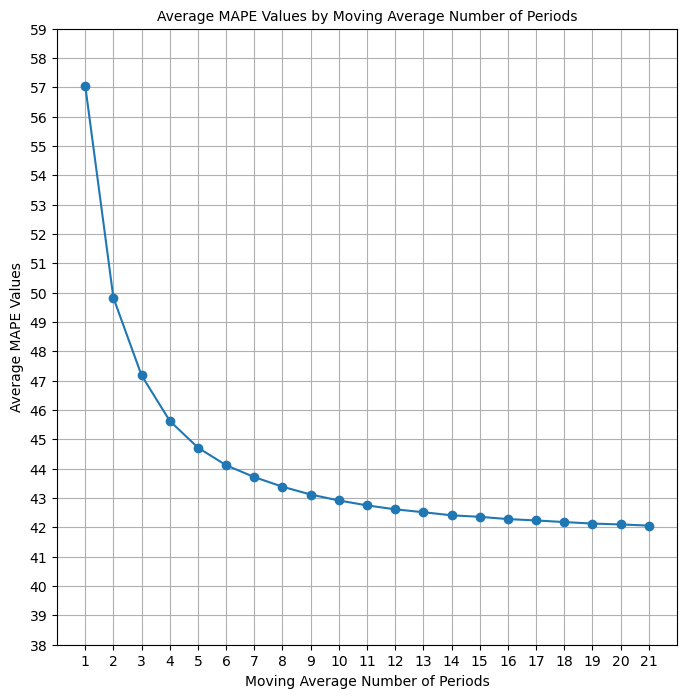

In [25]:
dictionary = {1:Average_MAPE(NFL_1Game_AVG_mapeDictionary),
              2:Average_MAPE(NFL_2Game_AVG_mapeDictionary),
              3:Average_MAPE(NFL_3Game_AVG_mapeDictionary),
              4:Average_MAPE(NFL_4Game_AVG_mapeDictionary),
              5:Average_MAPE(NFL_5Game_AVG_mapeDictionary),
              6:Average_MAPE(NFL_6Game_AVG_mapeDictionary),
              7:Average_MAPE(NFL_7Game_AVG_mapeDictionary),
              8:Average_MAPE(NFL_8Game_AVG_mapeDictionary),
              9:Average_MAPE(NFL_9Game_AVG_mapeDictionary),
              10:Average_MAPE(NFL_10Game_AVG_mapeDictionary),
              11:Average_MAPE(NFL_11Game_AVG_mapeDictionary),
              12:Average_MAPE(NFL_12Game_AVG_mapeDictionary),
              13:Average_MAPE(NFL_13Game_AVG_mapeDictionary),
              14:Average_MAPE(NFL_14Game_AVG_mapeDictionary),
              15:Average_MAPE(NFL_15Game_AVG_mapeDictionary),
              16:Average_MAPE(NFL_16Game_AVG_mapeDictionary),
              17:Average_MAPE(NFL_17Game_AVG_mapeDictionary),
              18:Average_MAPE(NFL_18Game_AVG_mapeDictionary),
              19:Average_MAPE(NFL_19Game_AVG_mapeDictionary),
              20:Average_MAPE(NFL_20Game_AVG_mapeDictionary),
              21:Average_MAPE(NFL_21Game_AVG_mapeDictionary)}

figure = plt.figure(figsize=(8,8))
plt.plot(list(dictionary.keys()), list(dictionary.values()), marker = "o")
plt.xticks([x for x in range(1,22)])
plt.yticks([x for x in range(38,60)])
plt.title("Average MAPE Values by Moving Average Number of Periods", size = 10)
plt.ylabel("Average MAPE Values")
plt.xlabel("Moving Average Number of Periods")
plt.grid(True)

***Printing out the 21 average MAPE values***

In [26]:
print(f"{'{0: <16}'.format('1 Game Average:')} {Average_MAPE(NFL_1Game_AVG_mapeDictionary):.7}")
print(f"{'{0: <16}'.format('2 Game Average:')} {Average_MAPE(NFL_2Game_AVG_mapeDictionary):.7}")
print(f"{'{0: <16}'.format('3 Game Average:')} {Average_MAPE(NFL_3Game_AVG_mapeDictionary):.7}")
print(f"{'{0: <16}'.format('4 Game Average:')} {Average_MAPE(NFL_4Game_AVG_mapeDictionary):.7}")
print(f"{'{0: <16}'.format('5 Game Average:')} {Average_MAPE(NFL_5Game_AVG_mapeDictionary):.7}")
print(f"{'{0: <16}'.format('6 Game Average:')} {Average_MAPE(NFL_6Game_AVG_mapeDictionary):.7}")
print(f"{'{0: <16}'.format('7 Game Average:')} {Average_MAPE(NFL_7Game_AVG_mapeDictionary):.7}")
print(f"{'{0: <16}'.format('8 Game Average:')} {Average_MAPE(NFL_8Game_AVG_mapeDictionary):.7}")
print(f"{'{0: <16}'.format('9 Game Average:')} {Average_MAPE(NFL_9Game_AVG_mapeDictionary):.7}")
print(f"10 Game Average: {Average_MAPE(NFL_10Game_AVG_mapeDictionary):.7}")
print(f"11 Game Average: {Average_MAPE(NFL_11Game_AVG_mapeDictionary):.7}")
print(f"12 Game Average: {Average_MAPE(NFL_12Game_AVG_mapeDictionary):.7}")
print(f"13 Game Average: {Average_MAPE(NFL_13Game_AVG_mapeDictionary):.7}")
print(f"14 Game Average: {Average_MAPE(NFL_14Game_AVG_mapeDictionary):.7}")
print(f"15 Game Average: {Average_MAPE(NFL_15Game_AVG_mapeDictionary):.7}")
print(f"16 Game Average: {Average_MAPE(NFL_16Game_AVG_mapeDictionary):.7}")
print(f"17 Game Average: {Average_MAPE(NFL_17Game_AVG_mapeDictionary):.7}")
print(f"18 Game Average: {Average_MAPE(NFL_18Game_AVG_mapeDictionary):.7}")
print(f"19 Game Average: {Average_MAPE(NFL_19Game_AVG_mapeDictionary):.7}")
print(f"20 Game Average: {Average_MAPE(NFL_20Game_AVG_mapeDictionary):.7}")
print(f"21 Game Average: {Average_MAPE(NFL_21Game_AVG_mapeDictionary):.7}")

1 Game Average:  57.06298
2 Game Average:  49.82994
3 Game Average:  47.18131
4 Game Average:  45.6312
5 Game Average:  44.71858
6 Game Average:  44.11817
7 Game Average:  43.71503
8 Game Average:  43.38635
9 Game Average:  43.12061
10 Game Average: 42.91752
11 Game Average: 42.75024
12 Game Average: 42.61501
13 Game Average: 42.51739
14 Game Average: 42.41158
15 Game Average: 42.36071
16 Game Average: 42.2829
17 Game Average: 42.23643
18 Game Average: 42.18173
19 Game Average: 42.12995
20 Game Average: 42.10049
21 Game Average: 42.06093


---

---

## Data Modeling

After doing the preliminary modeling, some further things that I wanted to do:
- try to see if i balance the number of home and away games to see if that will improve model performance since there is an imbalance between home game wins and away game wins
- try other models

The Game Average data that was chosen to use for the modeling was the `NFL_14Game_AVG`. This choice was made becuase average MAPE values across the numerical columns start to have a small decreases in the average MAPE values at the 14 previous game mark. 

**Splitting data into training, testing, and validation sets** 

In [27]:
validation_data = NFL_14Game_AVG.loc[("2022-09-01" <= NFL_14Game_AVG.date) & (NFL_14Game_AVG.date <= "2023-01-14")]
x_val = validation_data.iloc[:, 6:]
y_val = validation_data.game_result

In [30]:
validation_index = validation_data.index.values.tolist()
training_testing_data = NFL_14Game_AVG.drop(validation_index)

X = training_testing_data.iloc[:, 6:]
y = training_testing_data.game_result

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.105,
                                                    random_state = 15)

In [31]:
print(f"Training Data: [X_train {len(X_train)}, y_train {len(y_train)}] | Testing Data [X_test {len(X_test)}, y_test {len(y_test)}] \nValidation Data [X_Validate {len(x_val)}, y_validate {len(y_val)}]")

Training Data: [X_train 2296, y_train 2296] | Testing Data [X_test 270, y_test 270] 
Validation Data [X_Validate 269, y_validate 269]


### K-Nearest Neighbor Model

**Finding the optimal number of neighbors for the K-Nearest Neighbor Model**  
I want to try and find the optimal number of neighbors to run with the KNN Model. To do this, I loop through the process of creating a KNN classifier model where each loop increases the number of neighbors being looked at in predicting new data points. In this KNN classifier model, the `weights = 'distance'` parameter is used in the model. This parameter prioritizes datapoints that are closest to the new datapoint in making its prediction.

In finding the optimal number of neighbors, I save the testing accuracy and valudation accuracy scores to lists named `optimal_testScore` and `optimal_validationScore`. The list are then used in another cell to create a visualization that plots the the values within the two lists as line graphs. Where the line depicts the testing and validation accuracy scores for the given number of neighbors. 

In [32]:
optimal_testScore = list()
optimal_validationScore = list()

for value in range(1, 76):
    print(f"Number of Neighbors: {value}")
    optimalNeighbor = KNeighborsClassifier(weights='distance', n_neighbors=value)
    optimalNeighbor.fit(X_train, y_train)
    
    y_pred = optimalNeighbor.predict(X_test)
    print(f"Testing Data Accuracy: {optimalNeighbor.score(X_test, y_test)}")
    optimal_testScore.append(optimalNeighbor.score(X_test, y_test))
    
    y_val_predictions = optimalNeighbor.predict(x_val)
    print(f"Validation Data Accuracy: {optimalNeighbor.score(x_val, y_val)}\n")
    optimal_validationScore.append(optimalNeighbor.score(x_val, y_val))

Number of Neighbors: 1
Testing Data Accuracy: 0.5296296296296297
Validation Data Accuracy: 0.5353159851301115

Number of Neighbors: 2
Testing Data Accuracy: 0.5296296296296297
Validation Data Accuracy: 0.5353159851301115

Number of Neighbors: 3
Testing Data Accuracy: 0.562962962962963
Validation Data Accuracy: 0.5687732342007435

Number of Neighbors: 4
Testing Data Accuracy: 0.5296296296296297
Validation Data Accuracy: 0.5687732342007435

Number of Neighbors: 5
Testing Data Accuracy: 0.5703703703703704
Validation Data Accuracy: 0.5650557620817844

Number of Neighbors: 6
Testing Data Accuracy: 0.5666666666666667
Validation Data Accuracy: 0.5762081784386617

Number of Neighbors: 7
Testing Data Accuracy: 0.6037037037037037
Validation Data Accuracy: 0.5910780669144982

Number of Neighbors: 8
Testing Data Accuracy: 0.5814814814814815
Validation Data Accuracy: 0.587360594795539

Number of Neighbors: 9
Testing Data Accuracy: 0.5962962962962963
Validation Data Accuracy: 0.6096654275092936

Num

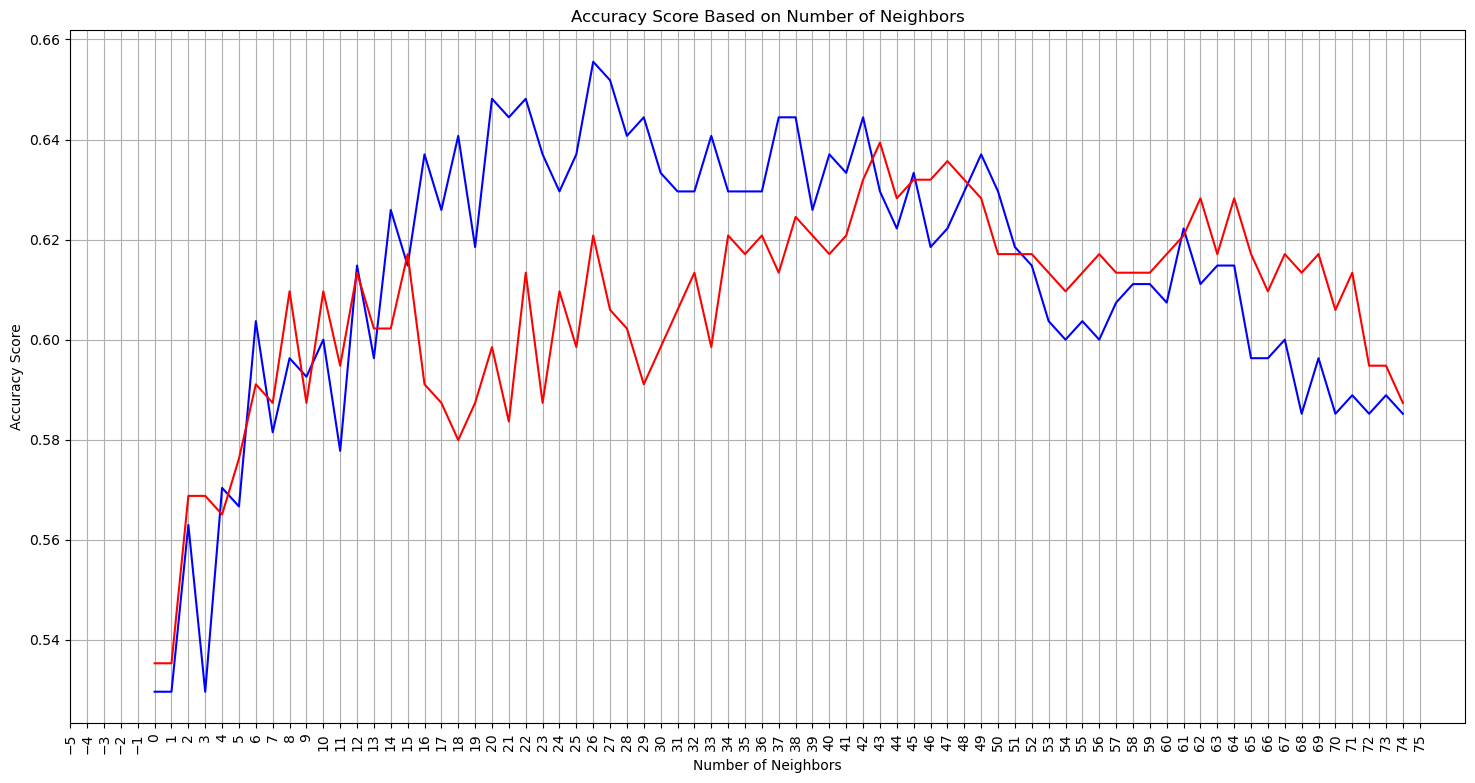

In [33]:
optimalFigure = plt.figure(figsize = (18, 9))
plt.plot(optimal_testScore, color = "blue")
plt.plot(optimal_validationScore, color = "red")
plt.title("Accuracy Score Based on Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.xlabel("Number of Neighbors")
plt.xticks([value for value in range(-5, 76)], rotation = "vertical")
plt.grid(True)

**Running the optimal KNN Classifier Model**  
It was found that the optimal KNN classifier Model was looking at 43 neighbors in making predictions for new datapoints. The following cells create the KNN Classifier model with the `weights = 'distance'` parameter and 43 neighbors. Fits the model the X_train and y_train datapoints that were created earlier. Then makes predictions for the testing and validation data. For the testing and validation data, the classification reports and confusion matrices were created in evaluating the performance of the model on the data.

***Model Creation***

In [34]:
neighbor_classifier = KNeighborsClassifier(weights = 'distance', n_neighbors=43)
neighbor_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=43, weights='distance')

***Model Predictions***

In [35]:
y_test_predictions = neighbor_classifier.predict(X_test)
y_val_predictions  = neighbor_classifier.predict(x_val)

***Model Accuracy Scores***

*Testing Data*

In [36]:
print(f"{neighbor_classifier.score(X_test, y_test):.5f}")

0.64444


*Validation Data*

In [37]:
print(f"{neighbor_classifier.score(x_val, y_val):.5f}")

0.63197


***Testing Data Performance***  
*Classification Report*

In [38]:
print(classification_report(y_test, y_test_predictions))

              precision    recall  f1-score   support

           0       0.67      0.52      0.59       130
           1       0.63      0.76      0.69       140

    accuracy                           0.64       270
   macro avg       0.65      0.64      0.64       270
weighted avg       0.65      0.64      0.64       270



*Confusion Matrix*

Text(0.5, 1.0, 'K-Nearest Neighbors Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

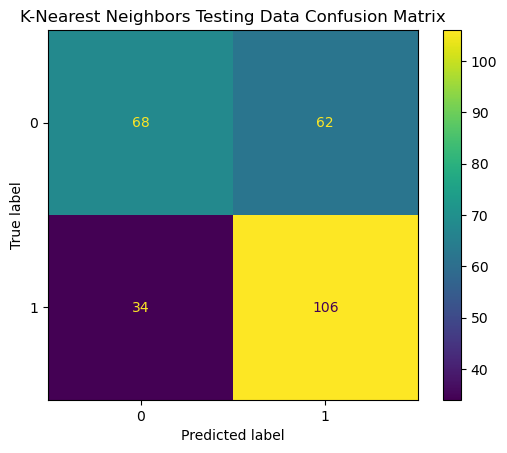

In [39]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_test, y_test_predictions, labels = neighbor_classifier.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = neighbor_classifier.classes_)
conf_matrix_display.plot()
plt.title(f"K-Nearest Neighbors Testing Data Confusion Matrix")

***Validation Data Performance***  
*Classification Report*

In [40]:
print(classification_report(y_val, y_val_predictions))

              precision    recall  f1-score   support

           0       0.61      0.45      0.52       118
           1       0.64      0.77      0.70       151

    accuracy                           0.63       269
   macro avg       0.63      0.61      0.61       269
weighted avg       0.63      0.63      0.62       269



*Confusion Matrix*

Text(0.5, 1.0, 'K-Nearest Neighbors Validation Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

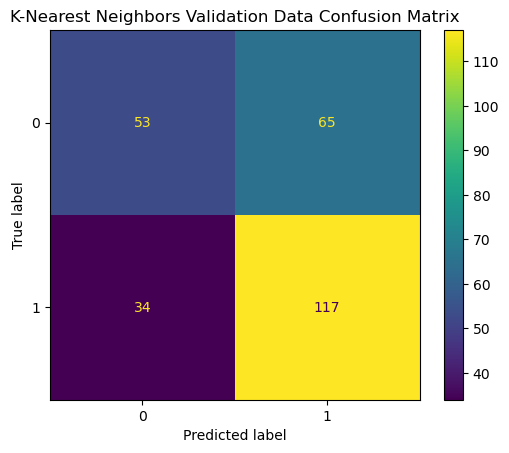

In [41]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_val, y_val_predictions, labels = neighbor_classifier.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = neighbor_classifier.classes_)
conf_matrix_display.plot()
plt.title(f"K-Nearest Neighbors Validation Data Confusion Matrix")

**Conclusions on KNN Classifier Model**  
The model was able to have accuracy scores for the testing and validation data of 64.444% and 63.197% respectfully. In applications such as sports betting, hitting on 63 to 64% of games would be a great rate to be at. However, one thing that I noticed on the KNN Classifier confusion matricies is the the high number of false negatives - where the true label was an away team won, but the home team actually won.

### Gaussian Naive Bayes Model

***Model Creation***

In [42]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB()

***Model Predictions***

In [43]:
y_test_predictions = naive_bayes.predict(X_test)
y_val_predictions  = naive_bayes.predict(x_val)

***Model Accuracy Scores***

*Testing Data*

In [44]:
print(f"{naive_bayes.score(X_test, y_test):.5f}")

0.63704


*Validation Data*

In [45]:
print(f"{naive_bayes.score(x_val, y_val):.5f}")

0.65056


**Testing Data Performance**  
*Classification Report*

In [46]:
print(classification_report(y_test, y_test_predictions))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       130
           1       0.64      0.68      0.66       140

    accuracy                           0.64       270
   macro avg       0.64      0.64      0.64       270
weighted avg       0.64      0.64      0.64       270



*Confusion Matrix*

Text(0.5, 1.0, 'Gaussian Naive_Bayes Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

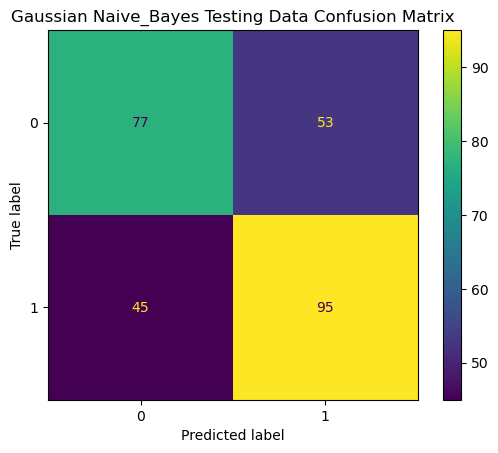

In [47]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_test, y_test_predictions, labels = naive_bayes.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = naive_bayes.classes_)
conf_matrix_display.plot()
plt.title(f"Gaussian Naive_Bayes Testing Data Confusion Matrix")

***Validation Data Performance***  
*Classification Report*

In [48]:
print(classification_report(y_val, y_val_predictions))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       118
           1       0.71      0.65      0.68       151

    accuracy                           0.65       269
   macro avg       0.65      0.65      0.65       269
weighted avg       0.66      0.65      0.65       269



*Confusion Matrix*

Text(0.5, 1.0, 'Gaussian Naive_Bayes Validation Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

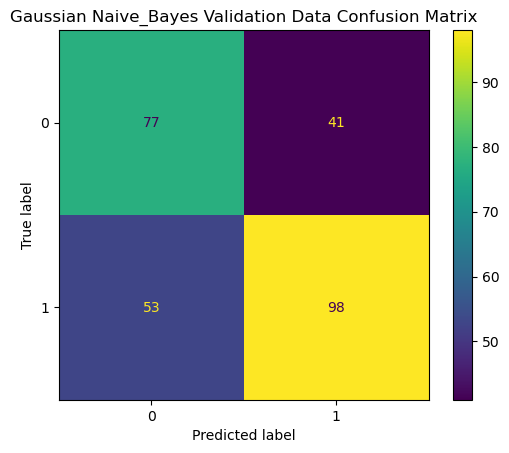

In [49]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_val, y_val_predictions, labels = naive_bayes.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = naive_bayes.classes_)
conf_matrix_display.plot()
plt.title(f"Gaussian Naive_Bayes Validation Data Confusion Matrix")

**Conclusions on Gaussian Naive Bayes Model**  
With the Gaussian Naive Bayes Model using prior probabilities/likelihood of a team having certain average statistics spanning back to the previous 14 games, the model was able to perform slightly better than the KNN Classifier Model. The Gaussian Navie Bayes Model was able to acheive accuracy scores of 63.7% and 65.1% on the testing and validation data. Looking at the confusion matricies for the testing and validation data, it appears that the Gaussian Naive Bayes Model was able to more accurately predict away team wins, despite the imbalance between the home and away team wins, as there are fewer false negatives than the KNN Model

### Random Forest Classifier Model

***Model Creation***

In [50]:
RandomForest = RandomForestClassifier(random_state=15)
RandomForest.fit(X_train, y_train)

RandomForestClassifier(random_state=15)

***Model Predictions***

In [51]:
y_pred = RandomForest.predict(X_test)
y_val_pred = RandomForest.predict(x_val)

***Model Accuracy Scores***

*Testing Data*

In [52]:
print(f"{RandomForest.score(X_test, y_test):.5f}")

0.62963


*Validation Data*

In [53]:
print(f"{RandomForest.score(x_val, y_val):.5f}")

0.60595


**Testing Data Performance**  
*Classification Report*

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.48      0.55       130
           1       0.61      0.77      0.68       140

    accuracy                           0.63       270
   macro avg       0.64      0.62      0.62       270
weighted avg       0.64      0.63      0.62       270



*Confusion Matrix*

Text(0.5, 1.0, 'Random Forest Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

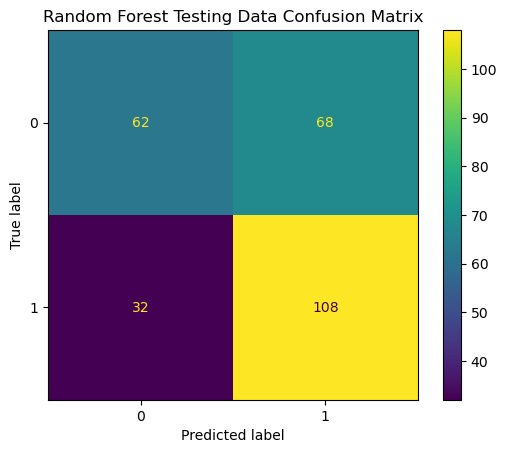

In [55]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_test, y_pred, labels = RandomForest.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = RandomForest.classes_)
conf_matrix_display.plot()
plt.title("Random Forest Testing Data Confusion Matrix")

**Validation Data Performance**  
*Classification Report*

In [56]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53       118
           1       0.64      0.69      0.66       151

    accuracy                           0.61       269
   macro avg       0.60      0.59      0.59       269
weighted avg       0.60      0.61      0.60       269



*Confusion Matrix*

Text(0.5, 1.0, 'Random Forest Validation Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

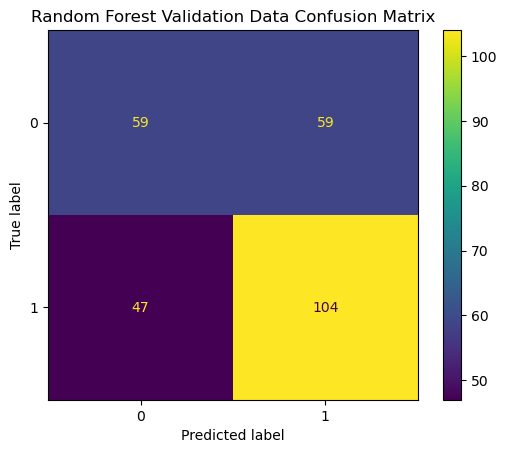

In [57]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_val, y_val_pred, labels = RandomForest.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = RandomForest.classes_)
conf_matrix_display.plot()
plt.title(f"Random Forest Validation Data Confusion Matrix")

**Finding the important features by using the feature_importances_ method**

In [58]:
RandomForest.feature_importances_

array([0.01636943, 0.00935647, 0.01221259, 0.00588581, 0.01041943,
       0.01157861, 0.01215639, 0.01188907, 0.01175985, 0.0143847 ,
       0.02066601, 0.01209207, 0.01410905, 0.00832185, 0.01294318,
       0.01165972, 0.01060521, 0.01212878, 0.00631453, 0.00816097,
       0.01363522, 0.0106365 , 0.01021543, 0.00900103, 0.00829341,
       0.0133841 , 0.01163257, 0.01214331, 0.01154396, 0.01312116,
       0.01366144, 0.01115677, 0.01005344, 0.0121461 , 0.00734639,
       0.00821066, 0.00939906, 0.01036997, 0.01284198, 0.00628858,
       0.0085951 , 0.01228155, 0.01139964, 0.01420127, 0.01221245,
       0.00979545, 0.0099236 , 0.00650408, 0.00967135, 0.00971898,
       0.01082523, 0.01143207, 0.01367152, 0.01395848, 0.01455247,
       0.00989505, 0.01470716, 0.00979835, 0.01204404, 0.01184956,
       0.01173053, 0.01413674, 0.00656343, 0.00949928, 0.01465411,
       0.0124798 , 0.01018998, 0.01033524, 0.00737188, 0.00920167,
       0.01245353, 0.01372677, 0.01220097, 0.01683999, 0.01512

In [59]:
#Creating a dataframe of the feature importances, sorting the dataframe and showing the top 22
forest_importances = pd.DataFrame(RandomForest.feature_importances_, index=NFL_14Game_AVG.columns[6:])
forest_importances.rename(columns={0:"feature_importance"}, inplace=True)
forest_importances.sort_values(by="feature_importance", ascending=False, inplace=True)

In [60]:
forest_importances.head(22)

,feature_importance
offensive_total_yards_away,0.020666
defensive_total_yards_allowed_home,0.017990
defensive_rushing_attempts_home,0.016840
offensive_first_downs_away,0.016369
defensive_rushing_yards_allowed_home,0.015127
offensive_yards_lost_from_sacks_home,0.014707
team_offensive_time_of_possession_home,0.014654
defensive_sack_yards_home,0.014596
offensive_total_yards_home,0.014552
offensive_rushing_yards_away,0.014385


## Data Modeling After Data Reduction

One of the aspects that I wanted to see after doing the preliminart modeling, was finding the important features. In the cell aboove, is the display of the top 22 features which make up 25% of the overall number of features. With this knowledge, I plan on building another KNN, Gauissan Naive-Bayes, and Random Forest models, with the reduced data

### Reducing NFL_14Game_AVG Dataset

In [61]:
TopFreatures_list = ["date", 
                     "away", 
                     "home", 
                     "score_away", 
                     "score_home", 
                     "game_result",
                     "offensive_total_yards_away",
                     "defensive_total_yards_allowed_home",
                     "defensive_rushing_attempts_home",
                     "offensive_first_downs_away",
                     "defensive_rushing_yards_allowed_home",
                     "offensive_yards_lost_from_sacks_home",
                     "team_offensive_time_of_possession_home",
                     "defensive_sack_yards_home",
                     "offensive_total_yards_home",
                     "offensive_rushing_yards_away",
                     "opposing_team_possession_home",
                     "points_allowed_away",
                     "offensive_penalty_yards_home",
                     "offensive_yards_lost_from_sacks_away",
                     "offensive_rushing_yards_home",
                     "defensive_passing_attempts_home",
                     "offensive_rushing_attempts_home",
                     "defensive_rushing_yards_allowed_away",
                     "team_offensive_time_of_possession_away",
                     "defensive_fourth_down_conversion_attempts_away",
                     "defensive_rushing_attempts_away",
                     "opposing_team_penalty_yards_home"]

Top_features = NFL_14Game_AVG[TopFreatures_list]
Top_features

,date,away,home,score_away,score_home,game_result,offensive_total_yards_away,defensive_total_yards_allowed_home,defensive_rushing_attempts_home,offensive_first_downs_away,...,offensive_penalty_yards_home,offensive_yards_lost_from_sacks_away,offensive_rushing_yards_home,defensive_passing_attempts_home,offensive_rushing_attempts_home,defensive_rushing_yards_allowed_away,team_offensive_time_of_possession_away,defensive_fourth_down_conversion_attempts_away,defensive_rushing_attempts_away,opposing_team_penalty_yards_home
0,2012-09-05,Cowboys,Giants,24,17,0,367.571429,380.214286,27.857143,20.428571,...,48.357143,16.500000,88.071429,36.357143,25.214286,104.714286,31.184524,0.785714,24.642857,60.428571
1,2012-09-09,Colts,Bears,21,41,1,290.571429,345.642857,24.357143,16.000000,...,49.785714,13.428571,133.357143,39.071429,29.785714,145.000000,26.486905,0.357143,33.214286,43.785714
2,2012-09-09,Eagles,Browns,17,16,0,395.428571,338.500000,33.928571,21.571429,...,51.857143,10.428571,95.857143,28.857143,25.357143,107.785714,31.504762,1.000000,25.642857,48.785714
3,2012-09-09,Rams,Lions,23,27,1,273.928571,378.500000,26.071429,16.571429,...,69.428571,24.071429,93.428571,38.214286,20.785714,148.428571,28.236905,0.357143,31.428571,62.357143
4,2012-09-09,Patriots,Titans,34,13,0,408.714286,366.428571,28.357143,24.571429,...,59.285714,11.357143,94.357143,38.214286,23.857143,119.857143,28.796429,0.928571,25.785714,52.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,2023-01-08,Giants,Eagles,16,22,1,334.428571,299.357143,27.571429,21.071429,...,37.928571,15.071429,142.500000,30.928571,31.214286,147.000000,30.894048,1.142857,26.642857,45.857143
2831,2023-01-08,Cardinals,49ers,13,38,1,324.928571,316.785714,22.714286,19.214286,...,42.500000,20.857143,130.428571,37.000000,27.500000,117.071429,30.469048,1.000000,25.785714,46.571429
2832,2023-01-08,Rams,Seahawks,16,19,1,280.000000,362.428571,30.857143,16.857143,...,46.500000,23.214286,123.785714,32.500000,25.428571,110.571429,29.829762,1.214286,26.214286,46.500000
2833,2023-01-08,Cowboys,Commanders,6,26,1,376.500000,306.928571,26.142857,21.857143,...,48.357143,9.642857,124.428571,28.785714,30.928571,129.000000,30.460714,1.500000,28.428571,36.357143


### Test-Train-Validation Split

Similar to the previous models, the 2022 NFL season, the most recent NFL season in the data set will be used as the validation data. The validation data is first received from the Top_features dataset, then dropped. Then the training and testing data is created with a split of 10.5% so that the testing size closely matches the validation data.

In [62]:
validation_data_condensed = Top_features.loc[("2022-09-01" <= Top_features.date) & (Top_features.date <= "2023-01-14")]
x_condensed_val = validation_data_condensed.iloc[:, 6:]
y_condensed_val = validation_data_condensed.game_result

validation_index_condensed = validation_data_condensed.index.values.tolist()
training_testing_data_condensed = Top_features.drop(validation_index_condensed)

X_condensed = training_testing_data_condensed.iloc[:, 6:]
y_condensed = training_testing_data_condensed.game_result

X_condensed_train, X_condensed_test, y_condensed_train, y_condensed_test = train_test_split(X_condensed, y_condensed, 
                                                                                            test_size=0.105,
                                                                                            random_state = 15)

In [63]:
print(f"Training Data: [X_condensed_train {len(X_condensed_train)}, y_condensed_train {len(y_condensed_train)}] \
| Testing Data [X_condensed_test {len(X_condensed_test)}, y_condensed_test {len(y_condensed_test)}] \
\nValidation Data [X_condensed_Validate {len(x_condensed_val)}, y_condensed_validate {len(y_condensed_val)}]")

Training Data: [X_condensed_train 2296, y_condensed_train 2296] | Testing Data [X_condensed_test 270, y_condensed_test 270] 
Validation Data [X_condensed_Validate 269, y_condensed_validate 269]


### K-Nearest Neighbor Reduced Data Model

***Finding the optimal number of neighbors for the model***   
Similarly to the KNN Classifier Model ran earilier, I wanted to find the optimal number of neighbors for the KNN classifier model this time for the condensed data. The following two blocks of code iterate the process of generating a KNN Classifier Model on the condensed data, store the accuracy scores in the `optimal _condensed_testScore` and `optimal_condensed_validationScore` lists, then create a visualization of the accuracy scores

In [64]:
optimal_condensed_testScore = list()
optimal_condensed_validationScore = list()

for value in range(1, 101):
    print(f"Number of Neighbors: {value}")
    optimalNeighbor = KNeighborsClassifier(weights='distance', n_neighbors=value)
    optimalNeighbor.fit(X_condensed_train, y_condensed_train)
    
    y_pred = optimalNeighbor.predict(X_condensed_test)
    print(f"Testing Data Accuracy: {optimalNeighbor.score(X_condensed_test, y_condensed_test)}")
    optimal_condensed_testScore.append(optimalNeighbor.score(X_condensed_test, y_condensed_test))
    
    y_val_predictions = optimalNeighbor.predict(x_condensed_val)
    print(f"Validation Data Accuracy: {optimalNeighbor.score(x_condensed_val, y_condensed_val)}\n")
    optimal_condensed_validationScore.append(optimalNeighbor.score(x_condensed_val, y_condensed_val))

Number of Neighbors: 1
Testing Data Accuracy: 0.5666666666666667
Validation Data Accuracy: 0.5650557620817844

Number of Neighbors: 2
Testing Data Accuracy: 0.5666666666666667
Validation Data Accuracy: 0.5650557620817844

Number of Neighbors: 3
Testing Data Accuracy: 0.6111111111111112
Validation Data Accuracy: 0.5910780669144982

Number of Neighbors: 4
Testing Data Accuracy: 0.5740740740740741
Validation Data Accuracy: 0.5613382899628253

Number of Neighbors: 5
Testing Data Accuracy: 0.6
Validation Data Accuracy: 0.5576208178438662

Number of Neighbors: 6
Testing Data Accuracy: 0.5925925925925926
Validation Data Accuracy: 0.5687732342007435

Number of Neighbors: 7
Testing Data Accuracy: 0.6037037037037037
Validation Data Accuracy: 0.5799256505576208

Number of Neighbors: 8
Testing Data Accuracy: 0.5888888888888889
Validation Data Accuracy: 0.5762081784386617

Number of Neighbors: 9
Testing Data Accuracy: 0.5740740740740741
Validation Data Accuracy: 0.5799256505576208

Number of Neighb

Validation Data Accuracy: 0.5947955390334573

Number of Neighbors: 78
Testing Data Accuracy: 0.6185185185185185
Validation Data Accuracy: 0.587360594795539

Number of Neighbors: 79
Testing Data Accuracy: 0.6148148148148148
Validation Data Accuracy: 0.6022304832713755

Number of Neighbors: 80
Testing Data Accuracy: 0.6148148148148148
Validation Data Accuracy: 0.5947955390334573

Number of Neighbors: 81
Testing Data Accuracy: 0.6148148148148148
Validation Data Accuracy: 0.6096654275092936

Number of Neighbors: 82
Testing Data Accuracy: 0.6185185185185185
Validation Data Accuracy: 0.6022304832713755

Number of Neighbors: 83
Testing Data Accuracy: 0.6259259259259259
Validation Data Accuracy: 0.6096654275092936

Number of Neighbors: 84
Testing Data Accuracy: 0.6222222222222222
Validation Data Accuracy: 0.6022304832713755

Number of Neighbors: 85
Testing Data Accuracy: 0.6185185185185185
Validation Data Accuracy: 0.6059479553903345

Number of Neighbors: 86
Testing Data Accuracy: 0.6148148148

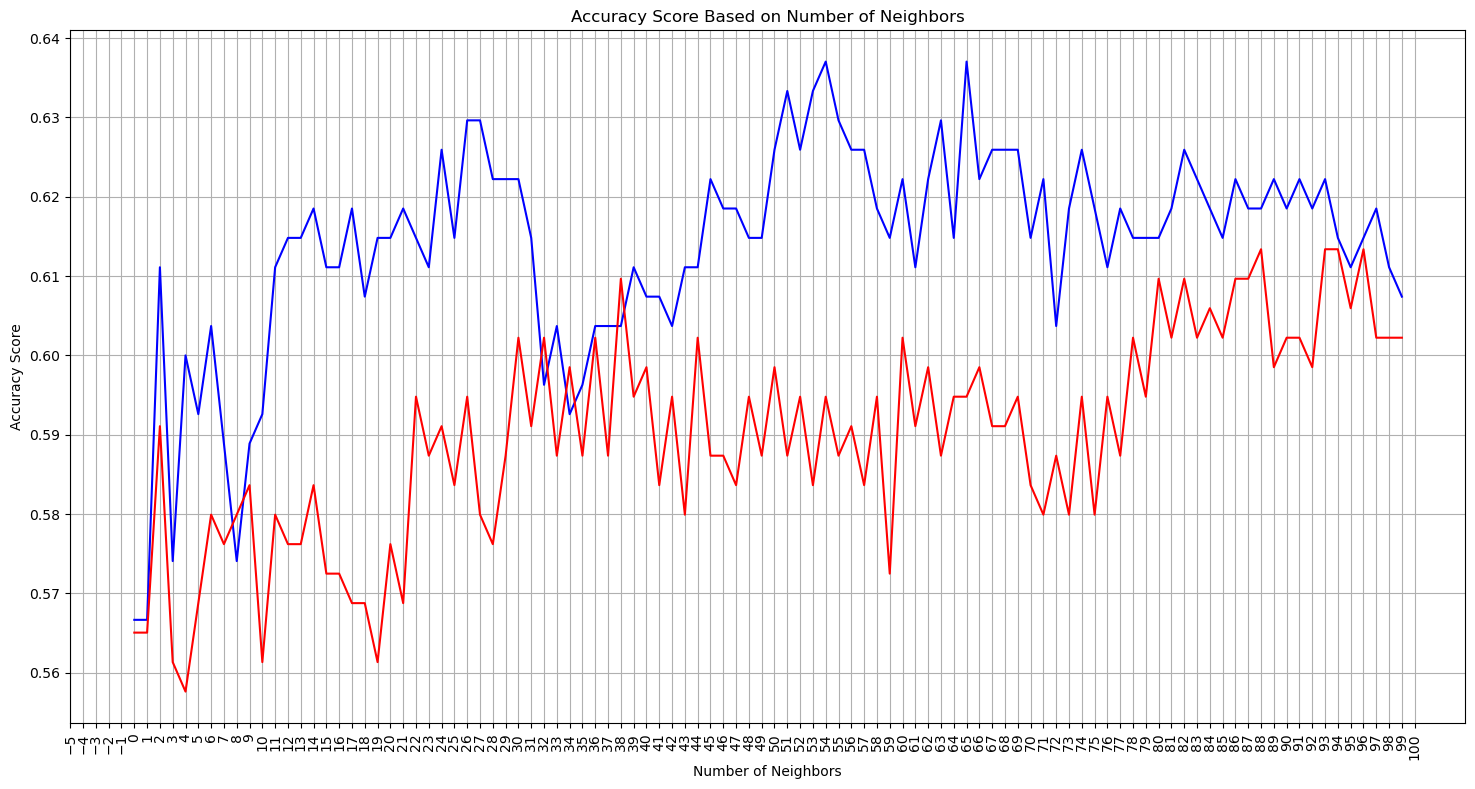

In [65]:
optimal_condensedFigure = plt.figure(figsize = (18, 9))
plt.plot(optimal_condensed_testScore, color = "blue")
plt.plot(optimal_condensed_validationScore, color = "red")
plt.title("Accuracy Score Based on Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.xlabel("Number of Neighbors")
plt.xticks([value for value in range(-5, 101)], rotation = "vertical")
plt.grid(True)

***Model Creation***

In [74]:
neighbor_classifier_condensed = KNeighborsClassifier(weights = 'distance', n_neighbors=38)
neighbor_classifier_condensed.fit(X_condensed_train, y_condensed_train)

KNeighborsClassifier(n_neighbors=38, weights='distance')

***Model Predictions***

In [75]:
y_condensed_test_predictions = neighbor_classifier_condensed.predict(X_condensed_test)
y_condensed_val_predictions  = neighbor_classifier_condensed.predict(x_condensed_val)

***Condensed Data Accuracy Scores***   
Testing Data

In [76]:
print(f"{neighbor_classifier_condensed.score(X_condensed_test, y_condensed_test):.5f}")

0.60370


Validation Data

In [77]:
print(f"{neighbor_classifier_condensed.score(x_condensed_val, y_condensed_val):.5f}")

0.58736


***Condensed Testing Data Performance***   
Classification Report

In [78]:
print(classification_report(y_condensed_test, y_condensed_test_predictions))

              precision    recall  f1-score   support

           0       0.61      0.48      0.54       130
           1       0.60      0.72      0.65       140

    accuracy                           0.60       270
   macro avg       0.61      0.60      0.60       270
weighted avg       0.61      0.60      0.60       270



Confusion Matrix

Text(0.5, 1.0, 'KNN Condensed Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

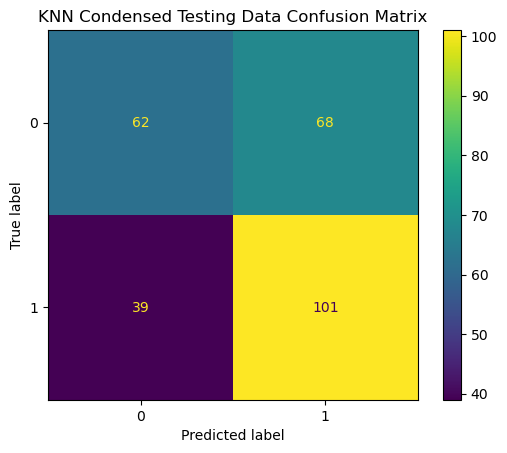

In [79]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_condensed_test, y_condensed_test_predictions, labels = neighbor_classifier_condensed.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = neighbor_classifier_condensed.classes_)
conf_matrix_display.plot()
plt.title(f"KNN Condensed Testing Data Confusion Matrix")

***Condensed Validation Data Performance***   
Classification Report

In [80]:
print(classification_report(y_condensed_val, y_condensed_val_predictions))

              precision    recall  f1-score   support

           0       0.54      0.42      0.47       118
           1       0.61      0.72      0.66       151

    accuracy                           0.59       269
   macro avg       0.58      0.57      0.57       269
weighted avg       0.58      0.59      0.58       269



Confusion Matrix

Text(0.5, 1.0, 'KNN Condensed Validation Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

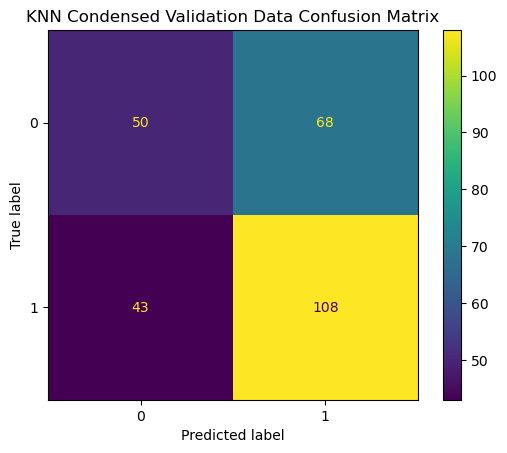

In [81]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_condensed_val, y_condensed_val_predictions, labels = neighbor_classifier_condensed.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = neighbor_classifier_condensed.classes_)
conf_matrix_display.plot()
plt.title(f"KNN Condensed Validation Data Confusion Matrix")

### Gaussian Naive Bayes Condensed Data Model

***Model Creation***

In [82]:
naive_bayes_condensed = GaussianNB()
naive_bayes_condensed.fit(X_condensed_train, y_condensed_train)

GaussianNB()

***Model Predictions***

In [83]:
y_condensed_test_predictions = naive_bayes_condensed.predict(X_condensed_test)
y_condensed_val_predictions  = naive_bayes_condensed.predict(x_condensed_val)

***Condensed Data Accuracy Scores***

Condensed Testing Data Accuracy Scores

In [84]:
print(f"{naive_bayes_condensed.score(X_condensed_test, y_condensed_test):.5f}")

0.63704


Condensed Validation Data Accuracy Scores

In [85]:
print(f"{naive_bayes_condensed.score(x_condensed_val, y_condensed_val):.5f}")

0.65428


***Condensed Testing Data Performance***   
Classification Report

In [86]:
print(classification_report(y_condensed_test, y_condensed_test_predictions))

              precision    recall  f1-score   support

           0       0.64      0.58      0.60       130
           1       0.64      0.69      0.66       140

    accuracy                           0.64       270
   macro avg       0.64      0.63      0.63       270
weighted avg       0.64      0.64      0.64       270



Confusion Matrix

Text(0.5, 1.0, 'Gaussian Naive_Bayes Condensed Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

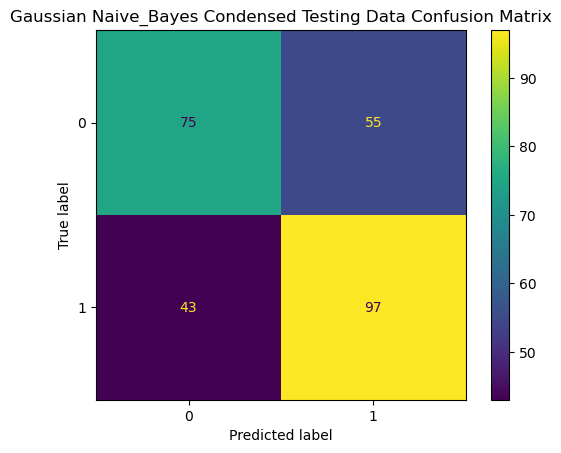

In [87]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_condensed_test, y_condensed_test_predictions, labels = naive_bayes_condensed.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = naive_bayes_condensed.classes_)
conf_matrix_display.plot()
plt.title(f"Gaussian Naive_Bayes Condensed Testing Data Confusion Matrix")

***Condensed Validation Data Performance***   
Classification Report

In [88]:
print(classification_report(y_condensed_val, y_condensed_val_predictions))

              precision    recall  f1-score   support

           0       0.59      0.67      0.63       118
           1       0.71      0.64      0.68       151

    accuracy                           0.65       269
   macro avg       0.65      0.66      0.65       269
weighted avg       0.66      0.65      0.66       269



Confusion Matrix

Text(0.5, 1.0, 'Gaussian Naive_Bayes Condensed Validation Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

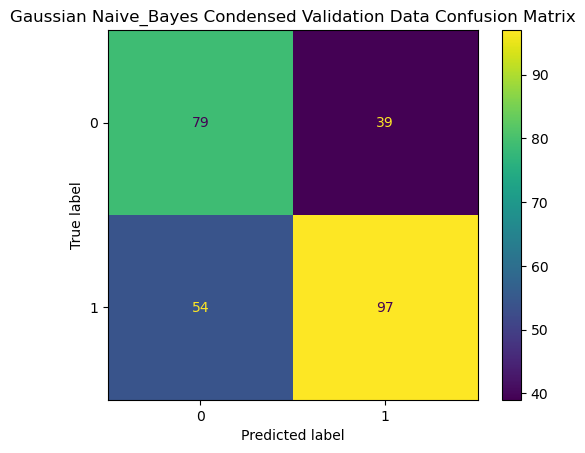

In [89]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_condensed_val, y_condensed_val_predictions, labels = naive_bayes_condensed.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = naive_bayes_condensed.classes_)
conf_matrix_display.plot()
plt.title(f"Gaussian Naive_Bayes Condensed Validation Data Confusion Matrix")

### Random Forest Condensed Data Model

***Model Creation***

In [90]:
RandomForest_condensed = RandomForestClassifier(random_state=15)
RandomForest_condensed.fit(X_condensed_train, y_condensed_train)

RandomForestClassifier(random_state=15)

***Model Predictions***

In [91]:
y_condensed_pred = RandomForest_condensed.predict(X_condensed_test)
y_condensed_val_pred = RandomForest_condensed.predict(x_condensed_val)

***Model Accuracy Scores***   
Condensed Testing Data Accuracy Scores

In [92]:
print(f"{RandomForest_condensed.score(X_condensed_test, y_condensed_test):.5f}")

0.61852


Condensed Validation Data Accuracy Scores

In [93]:
print(f"{RandomForest_condensed.score(x_condensed_val, y_condensed_val):.5f}")

0.62082


***Condensed Tesing Data Performance***   
Classification Report

In [94]:
print(classification_report(y_condensed_test, y_condensed_pred))

              precision    recall  f1-score   support

           0       0.64      0.48      0.55       130
           1       0.61      0.75      0.67       140

    accuracy                           0.62       270
   macro avg       0.62      0.61      0.61       270
weighted avg       0.62      0.62      0.61       270



Confusion Matrix

Text(0.5, 1.0, 'Random Forest Condensed Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

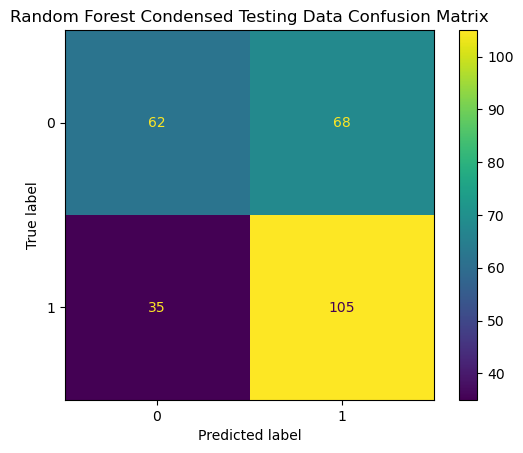

In [95]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_condensed_test, y_condensed_pred, labels = RandomForest_condensed.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = RandomForest_condensed.classes_)
conf_matrix_display.plot()
plt.title(f"Random Forest Condensed Testing Data Confusion Matrix")

***Condensed Validation Data Performance***  
Classification Report

In [96]:
print(classification_report(y_condensed_val, y_condensed_val_pred))

              precision    recall  f1-score   support

           0       0.57      0.54      0.56       118
           1       0.66      0.68      0.67       151

    accuracy                           0.62       269
   macro avg       0.61      0.61      0.61       269
weighted avg       0.62      0.62      0.62       269



Confusion Matrix

Text(0.5, 1.0, 'Random Froest Condensed Validation Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

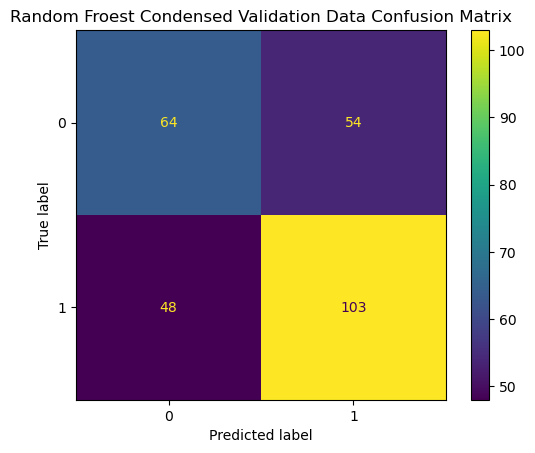

In [97]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_condensed_val, y_condensed_val_pred, labels = RandomForest_condensed.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = RandomForest_condensed.classes_)
conf_matrix_display.plot()
plt.title(f"Random Froest Condensed Validation Data Confusion Matrix")

**Conclusions on Models after data reduction**   
The models performed as expected. I expected that the models will lose a few points on their accuracy tests since the data that the models are being trained on do not have as much data to learn from. However, you do still see a relatively high number of false negatives in the confusion matricies for the three models. This brings me to the idea of balancing the dataset to possibly fix this issue.

## Data Modeling After Balancing the Data

One thing I noticed in the EDA and after the preliminary modeling, is that there is an imbalance in the number of home team and away team victories. As a result, I want to try and balance the team victories to see the effect balancing the data will have on the models performance. As you can see below, since 2012 home teams have won 1577 games compared to the 1258 games that the away team have won

In [98]:
NFL_14Game_AVG.game_result.value_counts()

game_result
1    1577
0    1258
Name: count, dtype: int64

***Balancing the Data***

In [99]:
homeWins = NFL_14Game_AVG.query("game_result == 1")
homeWins = resample(homeWins, replace = False, n_samples=1258, random_state=15)
awayWins = NFL_14Game_AVG.query("game_result == 0")

balanced_df = pd.concat([homeWins, awayWins], axis = 0)
balanced_df.reset_index(inplace=True, drop=True)
balanced_df

,date,away,home,score_away,score_home,game_result,offensive_first_downs_away,offensive_third_down_conversions_away,offensive_third_down_opportunities_away,offensive_fourth_down_conversions_away,...,defensive_fumbles_forced_home,defensive_int_forced_home,defensive_turnovers_forced_home,opposing_team_team_penalties_home,opposing_team_penalty_yards_home,opposing_team_def_st_td_home,opposing_team_drives_home,opposing_team_possession_home,points_scored_home,points_allowed_home
0,2022-09-18,Bears,Packers,10,27,1,20.142857,4.785714,13.214286,1.000000,...,0.357143,1.071429,1.428571,4.785714,36.000000,0.071429,10.357143,27.320238,19.928571,26.928571
1,2018-11-11,Cardinals,Chiefs,14,26,1,15.857143,3.857143,13.214286,0.214286,...,0.642857,1.142857,1.785714,7.071429,54.142857,0.142857,10.785714,30.048810,25.500000,31.571429
2,2013-11-03,Steelers,Patriots,31,55,1,17.857143,4.500000,13.214286,0.142857,...,0.928571,1.214286,2.142857,6.500000,57.500000,0.357143,12.928571,30.686905,20.928571,23.928571
3,2019-12-01,Chargers,Broncos,20,23,1,21.642857,5.142857,12.000000,0.428571,...,0.500000,0.642857,1.142857,7.214286,62.214286,0.428571,11.000000,30.357143,16.857143,18.714286
4,2015-11-15,Browns,Steelers,9,30,1,16.000000,5.142857,13.785714,0.357143,...,0.785714,0.785714,1.571429,6.428571,55.214286,0.000000,11.357143,31.001190,22.000000,23.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2023-01-07,Chiefs,Raiders,31,13,0,24.214286,5.714286,11.714286,0.571429,...,0.500000,0.357143,0.857143,5.071429,41.000000,0.142857,10.714286,29.927381,22.000000,26.142857
2512,2023-01-08,Vikings,Bears,29,13,0,22.500000,5.642857,13.571429,0.571429,...,0.428571,0.857143,1.285714,4.357143,34.785714,0.285714,10.571429,29.354762,23.285714,25.357143
2513,2023-01-08,Texans,Colts,32,31,0,16.000000,3.928571,12.785714,0.714286,...,0.642857,0.571429,1.214286,5.214286,44.642857,0.285714,11.500000,30.864286,18.642857,23.428571
2514,2023-01-08,Panthers,Saints,10,7,0,16.714286,3.571429,11.785714,0.785714,...,0.285714,0.357143,0.642857,5.285714,44.428571,0.214286,10.642857,30.273810,19.000000,22.071429


***Train-Test-Validation Splitting of the data***

In [100]:
validation_data_balanced = balanced_df.loc[("2022-09-01" <= balanced_df.date) & (balanced_df.date <= "2023-01-14")]
x_balanced_val = validation_data_balanced.iloc[:, 6:]
y_balanced_val = validation_data_balanced.game_result

validation_index_balanced = validation_data_balanced.index.values.tolist()
training_testing_data_balanced = balanced_df.drop(validation_index_balanced)

X_balanced = training_testing_data_balanced.iloc[:, 6:]
y_balanced = training_testing_data_balanced.game_result

X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, 
                                                                                            test_size=0.105,
                                                                                            random_state = 15)

### KNN Balanced Data Model

***Finding the optimal Number of Neighbors***

In [101]:
optimal_balanced_testScore = list()
optimal_balanced_validationScore = list()

for value in range(1, 101):
    print(f"Number of Neighbors: {value}")
    optimalNeighbor = KNeighborsClassifier(weights='distance', n_neighbors=value)
    optimalNeighbor.fit(X_balanced_train, y_balanced_train)
    
    y_pred = optimalNeighbor.predict(X_balanced_test)
    print(f"Testing Data Accuracy: {optimalNeighbor.score(X_balanced_test, y_balanced_test)}")
    optimal_balanced_testScore.append(optimalNeighbor.score(X_balanced_test, y_balanced_test))
    
    y_val_predictions = optimalNeighbor.predict(x_balanced_val)
    print(f"Validation Data Accuracy: {optimalNeighbor.score(x_balanced_val, y_balanced_val)}\n")
    optimal_balanced_validationScore.append(optimalNeighbor.score(x_balanced_val, y_balanced_val))

Number of Neighbors: 1
Testing Data Accuracy: 0.5188284518828452
Validation Data Accuracy: 0.44672131147540983

Number of Neighbors: 2
Testing Data Accuracy: 0.5188284518828452
Validation Data Accuracy: 0.44672131147540983

Number of Neighbors: 3
Testing Data Accuracy: 0.5271966527196653
Validation Data Accuracy: 0.5204918032786885

Number of Neighbors: 4
Testing Data Accuracy: 0.5397489539748954
Validation Data Accuracy: 0.5040983606557377

Number of Neighbors: 5
Testing Data Accuracy: 0.5397489539748954
Validation Data Accuracy: 0.5286885245901639

Number of Neighbors: 6
Testing Data Accuracy: 0.5439330543933054
Validation Data Accuracy: 0.5491803278688525

Number of Neighbors: 7
Testing Data Accuracy: 0.5481171548117155
Validation Data Accuracy: 0.5573770491803278

Number of Neighbors: 8
Testing Data Accuracy: 0.5481171548117155
Validation Data Accuracy: 0.5368852459016393

Number of Neighbors: 9
Testing Data Accuracy: 0.5648535564853556
Validation Data Accuracy: 0.569672131147541



Testing Data Accuracy: 0.6234309623430963
Validation Data Accuracy: 0.5942622950819673

Number of Neighbors: 80
Testing Data Accuracy: 0.6234309623430963
Validation Data Accuracy: 0.5983606557377049

Number of Neighbors: 81
Testing Data Accuracy: 0.6192468619246861
Validation Data Accuracy: 0.5942622950819673

Number of Neighbors: 82
Testing Data Accuracy: 0.606694560669456
Validation Data Accuracy: 0.5901639344262295

Number of Neighbors: 83
Testing Data Accuracy: 0.6150627615062761
Validation Data Accuracy: 0.5901639344262295

Number of Neighbors: 84
Testing Data Accuracy: 0.6192468619246861
Validation Data Accuracy: 0.5901639344262295

Number of Neighbors: 85
Testing Data Accuracy: 0.6192468619246861
Validation Data Accuracy: 0.5901639344262295

Number of Neighbors: 86
Testing Data Accuracy: 0.606694560669456
Validation Data Accuracy: 0.5983606557377049

Number of Neighbors: 87
Testing Data Accuracy: 0.6150627615062761
Validation Data Accuracy: 0.5942622950819673

Number of Neighbor

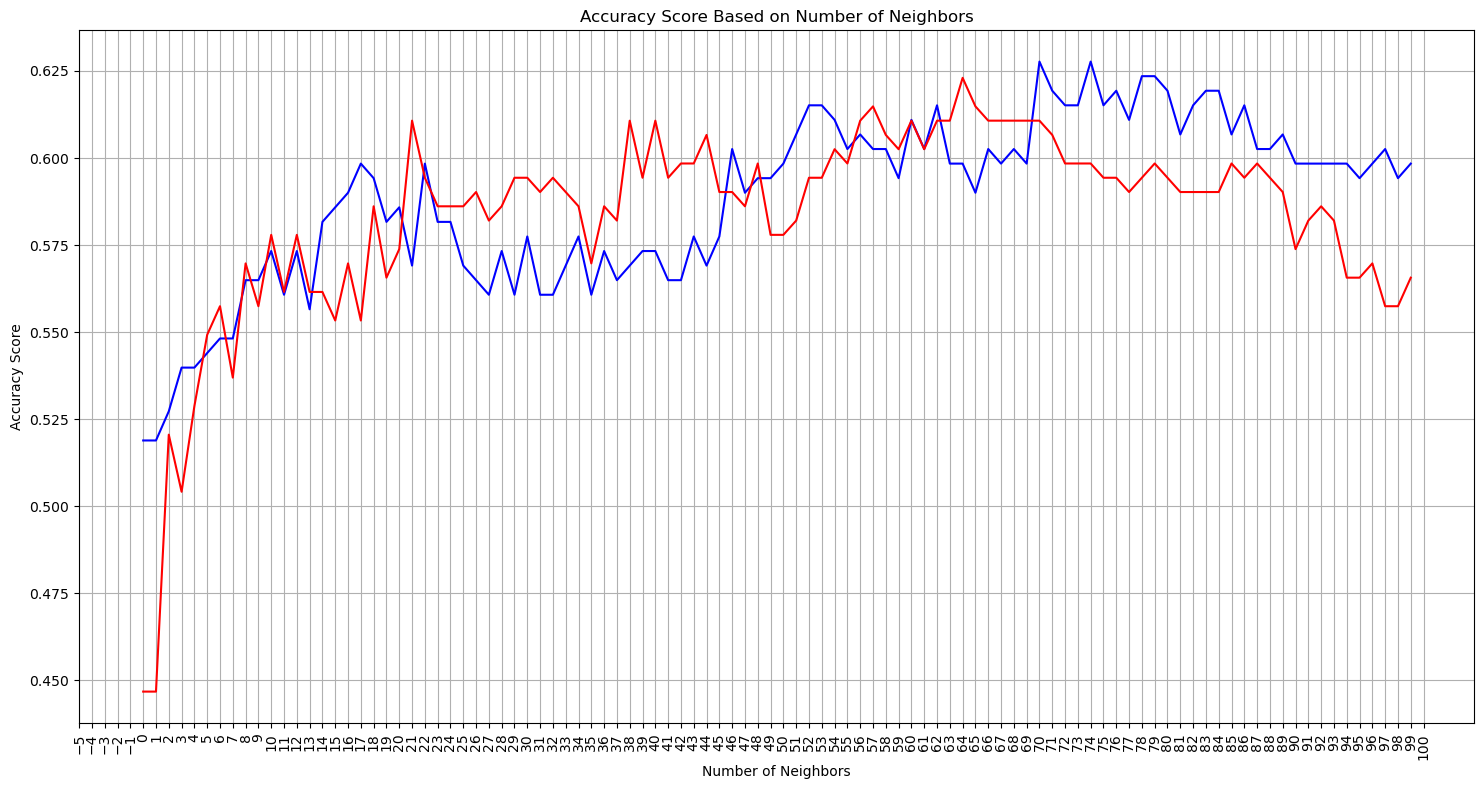

In [102]:
optimal_balancedFigure = plt.figure(figsize = (18, 9))
plt.plot(optimal_balanced_testScore, color = "blue")
plt.plot(optimal_balanced_validationScore, color = "red")
plt.title("Accuracy Score Based on Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.xlabel("Number of Neighbors")
plt.xticks([value for value in range(-5, 101)], rotation = "vertical")
plt.grid(True)

***Model Creation***

In [103]:
neighbor_classifier_balanced = KNeighborsClassifier(weights = 'distance', n_neighbors=61)
neighbor_classifier_balanced.fit(X_balanced_train, y_balanced_train)

KNeighborsClassifier(n_neighbors=61, weights='distance')

***Model Predictions***

In [104]:
y_balanced_test_predictions = neighbor_classifier_balanced.predict(X_balanced_test)
y_balanced_val_predictions  = neighbor_classifier_balanced.predict(x_balanced_val)

***Model Accuracy Scores***  
Balanced Testing Data

In [105]:
print(f"{neighbor_classifier_balanced.score(X_balanced_test, y_balanced_test):.5f}")

0.61088


Balanced Validation Data

In [106]:
print(f"{neighbor_classifier_balanced.score(x_balanced_val, y_balanced_val):.5f}")

0.61066


***Balanced Testing Data Performance***  
Classification Report

In [107]:
print(classification_report(y_balanced_test, y_balanced_test_predictions))

              precision    recall  f1-score   support

           0       0.57      0.70      0.63       112
           1       0.67      0.54      0.59       127

    accuracy                           0.61       239
   macro avg       0.62      0.62      0.61       239
weighted avg       0.62      0.61      0.61       239



Confusion Matrix

Text(0.5, 1.0, 'KNN Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

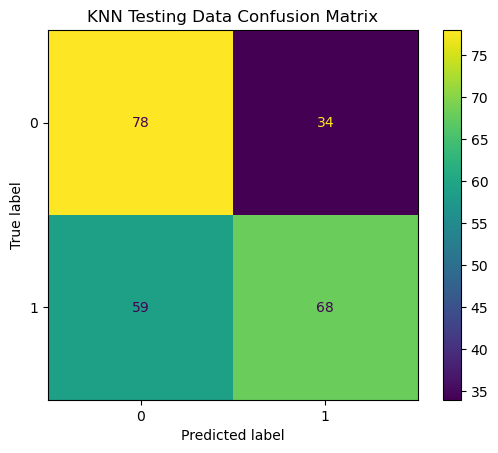

In [108]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_balanced_test, y_balanced_test_predictions, labels = neighbor_classifier_balanced.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = neighbor_classifier_balanced.classes_)
conf_matrix_display.plot()
plt.title(f"KNN Testing Data Confusion Matrix")

***Balanced Validation Data Performance***  
Classification Report

In [109]:
print(classification_report(y_balanced_val, y_balanced_val_predictions))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       118
           1       0.62      0.62      0.62       126

    accuracy                           0.61       244
   macro avg       0.61      0.61      0.61       244
weighted avg       0.61      0.61      0.61       244



Confusion Matrix

Text(0.5, 1.0, 'KNN Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

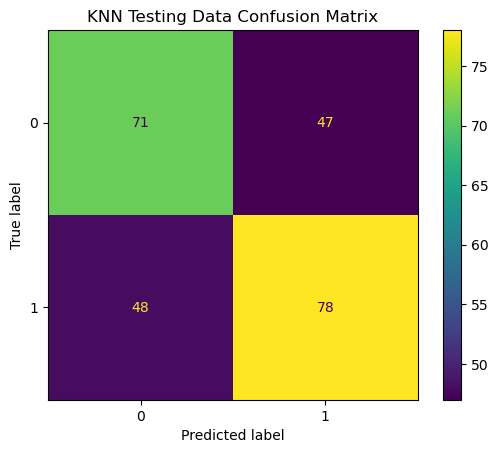

In [110]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_balanced_val, y_balanced_val_predictions, labels = neighbor_classifier_balanced.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = neighbor_classifier_balanced.classes_)
conf_matrix_display.plot()
plt.title(f"KNN Testing Data Confusion Matrix")

### Random Forest Balanced Data Model

***Model Creation***

In [111]:
RandomForest_balanced = RandomForestClassifier(random_state=15)
RandomForest_balanced.fit(X_balanced_train, y_balanced_train)

RandomForestClassifier(random_state=15)

***Model Predictions***

In [112]:
y_balanced_test_predictions = RandomForest_balanced.predict(X_balanced_test)
y_balanced_val_predictions  = RandomForest_balanced.predict(x_balanced_val)

***Model Accuracy Scores***  
Testing Data

In [113]:
print(f"{RandomForest_balanced.score(X_balanced_test, y_balanced_test):.5f}")

0.58159


Validation Data

In [114]:
print(f"{RandomForest_balanced.score(x_balanced_val, y_balanced_val):.5f}")

0.61066


***Testing Data Performance***

In [115]:
print(classification_report(y_balanced_test, y_balanced_test_predictions))

              precision    recall  f1-score   support

           0       0.54      0.67      0.60       112
           1       0.63      0.50      0.56       127

    accuracy                           0.58       239
   macro avg       0.59      0.59      0.58       239
weighted avg       0.59      0.58      0.58       239



Text(0.5, 1.0, 'Random Forest Balanced Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

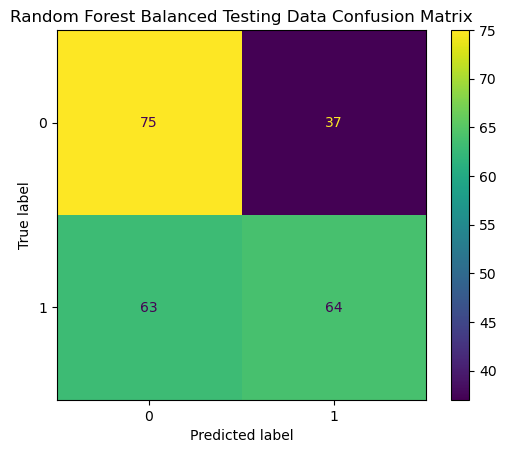

In [116]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_balanced_test, y_balanced_test_predictions, labels = RandomForest_balanced.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = RandomForest_balanced.classes_)
conf_matrix_display.plot()
plt.title(f"Random Forest Balanced Testing Data Confusion Matrix")

***Validation Data Performance***

In [117]:
print(classification_report(y_balanced_val, y_balanced_val_predictions))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64       118
           1       0.65      0.52      0.58       126

    accuracy                           0.61       244
   macro avg       0.62      0.61      0.61       244
weighted avg       0.62      0.61      0.61       244



Text(0.5, 1.0, 'Random Forest Balanced Validation Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

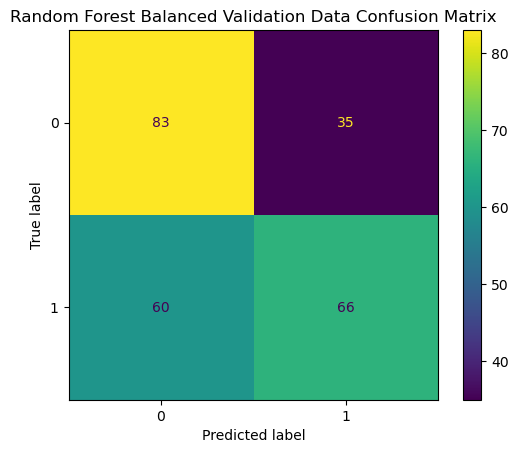

In [118]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_balanced_val, y_balanced_val_predictions, labels = RandomForest_balanced.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = RandomForest_balanced.classes_)
conf_matrix_display.plot()
plt.title(f"Random Forest Balanced Validation Data Confusion Matrix")

### Naive Bayes Balanced Models

**Model Creation**

In [119]:
naive_bayes_balanced = GaussianNB()
naive_bayes_balanced.fit(X_balanced_train, y_balanced_train)

GaussianNB()

**Model Predictions**

In [120]:
y_balanced_test_predictions = naive_bayes_balanced.predict(X_balanced_test)
y_balanced_val_predictions  = naive_bayes_balanced.predict(x_balanced_val)

**Testing Data Performance**

In [121]:
print(classification_report(y_balanced_test, y_balanced_test_predictions))

              precision    recall  f1-score   support

           0       0.57      0.64      0.60       112
           1       0.64      0.57      0.60       127

    accuracy                           0.60       239
   macro avg       0.60      0.60      0.60       239
weighted avg       0.61      0.60      0.60       239



Text(0.5, 1.0, 'Gaussian Naive_Bayes Balanced Testing Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

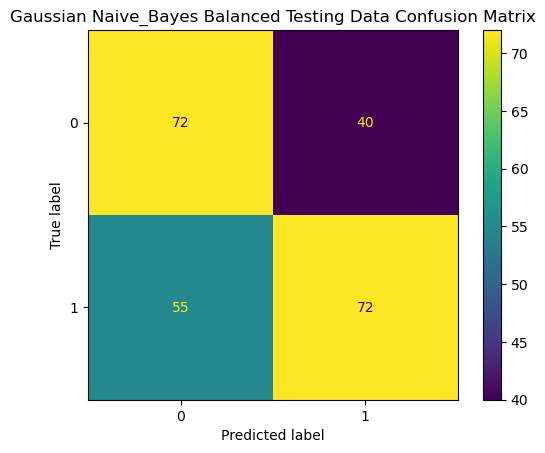

In [122]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_balanced_test, y_balanced_test_predictions, labels = naive_bayes_balanced.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = naive_bayes_balanced.classes_)
conf_matrix_display.plot()
plt.title(f"Gaussian Naive_Bayes Balanced Testing Data Confusion Matrix")

**Validation Data Performance**

In [123]:
print(classification_report(y_balanced_val, y_balanced_val_predictions))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       118
           1       0.66      0.63      0.65       126

    accuracy                           0.64       244
   macro avg       0.64      0.64      0.64       244
weighted avg       0.64      0.64      0.64       244



Text(0.5, 1.0, 'Gaussian Naive_Bayes Balanced Validation Data Confusion Matrix')

<Figure size 800x1000 with 0 Axes>

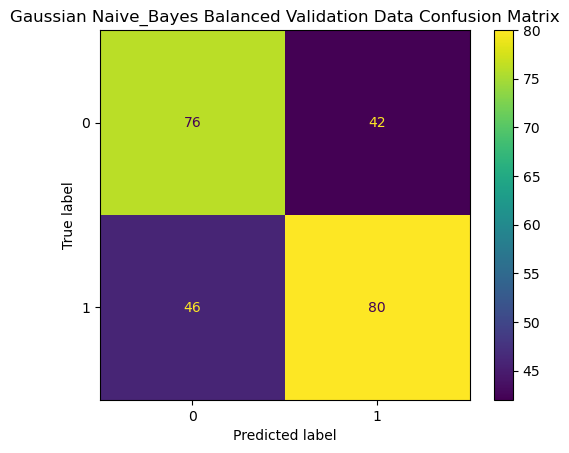

In [124]:
fig = plt.figure(figsize = (8,10))
conf_matrix = confusion_matrix(y_balanced_val, y_balanced_val_predictions, labels = naive_bayes_balanced.classes_)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = naive_bayes_balanced.classes_)
conf_matrix_display.plot()
plt.title(f"Gaussian Naive_Bayes Balanced Validation Data Confusion Matrix")

**Conclusions on balanced dataset models**  
Trying to account for the fact that false negatives in the earlier models in the data reduction and 14 game moving average datasets, has brought more false positives. In the confusion matricies of the KNN and Random Forest balanced data models, there a relatively high number of false positives that affect the accuracy scores of those models. Therefore, a future deeper dive is needed to further evaluate the data. Or this provides the notion of a true home field advantage in the NFL.